In [22]:
# !pip install --upgrade tensorflow
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
plt.style.use('fivethirtyeight')
%matplotlib inline

#for reading stock data from yahoo

from pandas_datareader.data import DataReader

#time stamps

from datetime import datetime
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
# python -m venv myenv
# source myenv/bin/activate  # On Windows: myenv\Scripts\activate

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf


In [20]:
import yfinance as yf
def collect_data(Symbol,start_date):
    stock_data=yf.download(Symbol,start=start_date,end=pd.Timestamp.now().strftime('%Y-%m-%d'))
    return stock_data
df = collect_data('MSFT','2021-01-01')
print(df.head())

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-01-04  222.529999  223.000000  214.809998  217.690002  210.844299   
2021-01-05  217.259995  218.520004  215.699997  217.899994  211.047668   
2021-01-06  212.169998  216.490005  211.940002  212.250000  205.575348   
2021-01-07  214.039993  219.339996  213.710007  218.289993  211.425400   
2021-01-08  218.679993  220.580002  217.029999  219.619995  212.713577   

              Volume  
Date                  
2021-01-04  37130100  
2021-01-05  23823000  
2021-01-06  35930700  
2021-01-07  27694500  
2021-01-08  22956200  


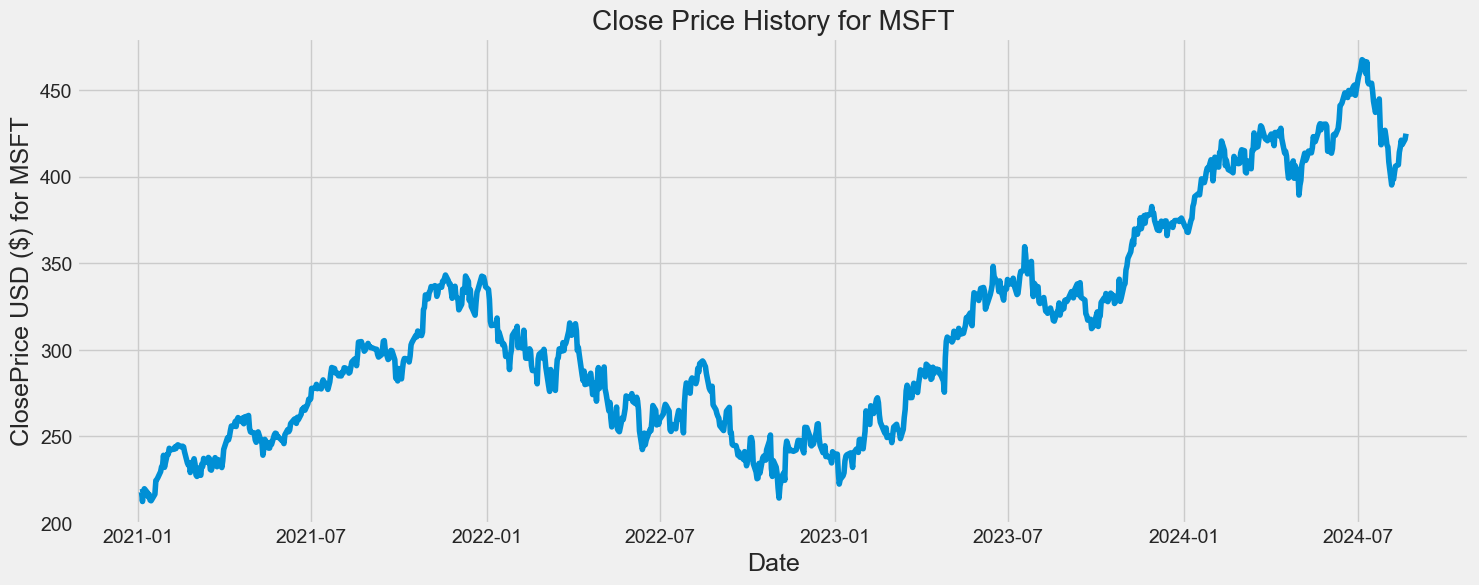

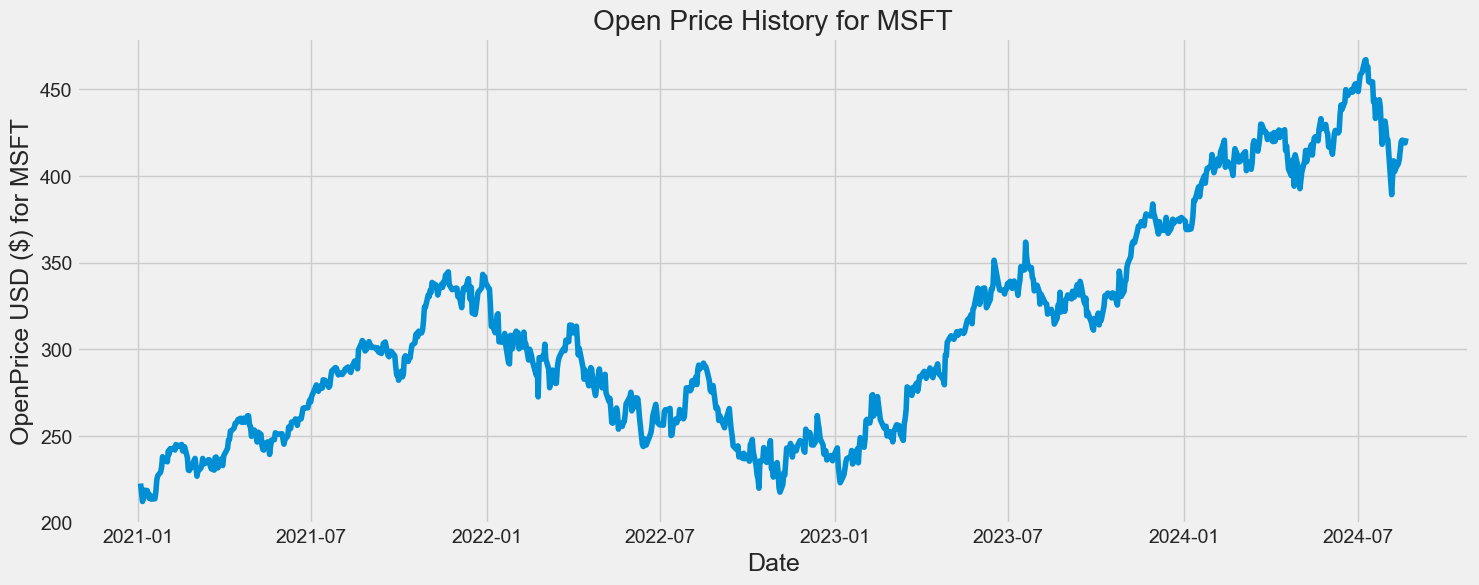

In [21]:
def plot_close_val(data_frame,column,stock):
    plt.figure(figsize=(16,6))
    plt.title(column+ ' Price History for '+ stock )
    plt.plot(data_frame[column])
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(column + 'Price USD ($) for ' + stock, fontsize=18)
    plt.show()
plot_close_val(df, 'Close', 'MSFT')
plot_close_val(df, 'Open', 'MSFT')

In [25]:
def build_training_dataset(input_ds):
     # Create a new dataframe with only the 'Close column 
    input_ds.reset_index()
    data=input_ds.filter(items=['Close'])
    # Convert the dataframe to a numpy array
    dataset=data.values
    # Get the number of rows to train the model on
    training_data_len=int(np.ceil(len(dataset)*.95))
    return data, dataset,training_data_len
training_data_df, training_dataset_np,training_data_len= build_training_dataset(df)
dataset=training_dataset_np
data=training_data_df


In [29]:
#MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
def scale_the_data(dataset):
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_data=scaler.fit_transform(dataset)
    return scaler, scaled_data
scaler,scaled_data= scale_the_data(training_dataset_np)

In [35]:
def split_train_dataset(training_data_len):
    train_data=scaled_data[0:int(training_data_len), :]
    x_train=[]
    y_train=[]
    for i in range(60,len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        if i<=61:
            print('.')

    x_train,y_train=np.array(x_train), np.array(y_train)
    x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

    return x_train, y_train

x_train,y_train=split_train_dataset(training_data_len)


.
.


In [36]:
def build_lstm_model(x_train,y_train):
    model= Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(x_train,y_train, batch_size=1, epochs=1)
    return model
lstm_model=build_lstm_model(x_train,y_train)

808/808 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.0050


In [40]:
def create_testing_data_set(model, scaler, training_data_len,test_data_len):
    test_data=scaled_data[training_data_len-test_data_len:, :]
     # Create the data sets x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(test_data_len, len(test_data)):
        x_test.append(test_data[i-test_data_len:i, 0])
    
    # Convert the data to a numpy array
    x_test = np.array(x_test)

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    # Get the models predicted price values 
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    rmse
    return (x_test, y_test, predictions, rmse)

#Test the function
TEST_DATA_LENGTH = 100
x_test,y_test, predictions, rmse = create_testing_data_set(lstm_model,scaler,training_data_len, TEST_DATA_LENGTH)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step


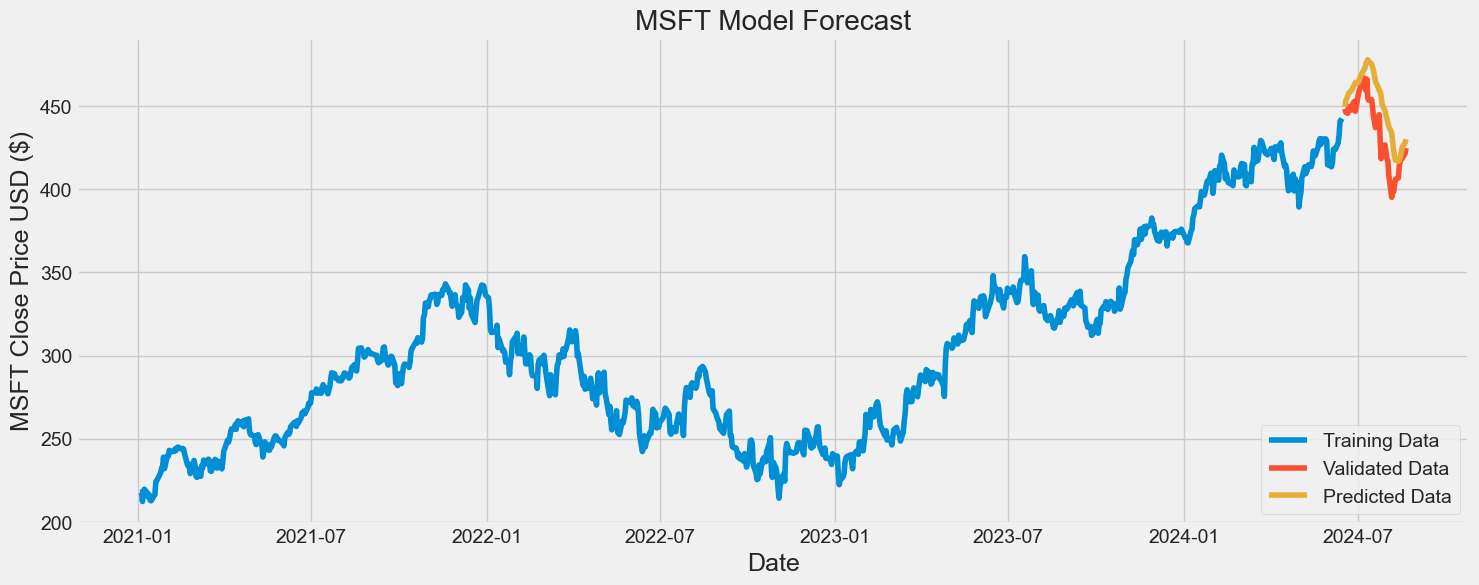

In [41]:
def plot_predictions(stock, data,training_data_len):
    #Plot the data
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    # Visualize the data
    plt.figure(figsize=(16,6))
    title = stock + ' Model Forecast'
    ylabel = stock + ' Close Price USD ($)'
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Training Data', 'Validated Data', 'Predicted Data'], loc='lower right')
    plt.show()
    return valid
    
#Test the function
valid = plot_predictions('MSFT',data,training_data_len)

[*********************100%%**********************]  1 of 1 completed

Let us evaluate for all of NASDAQ


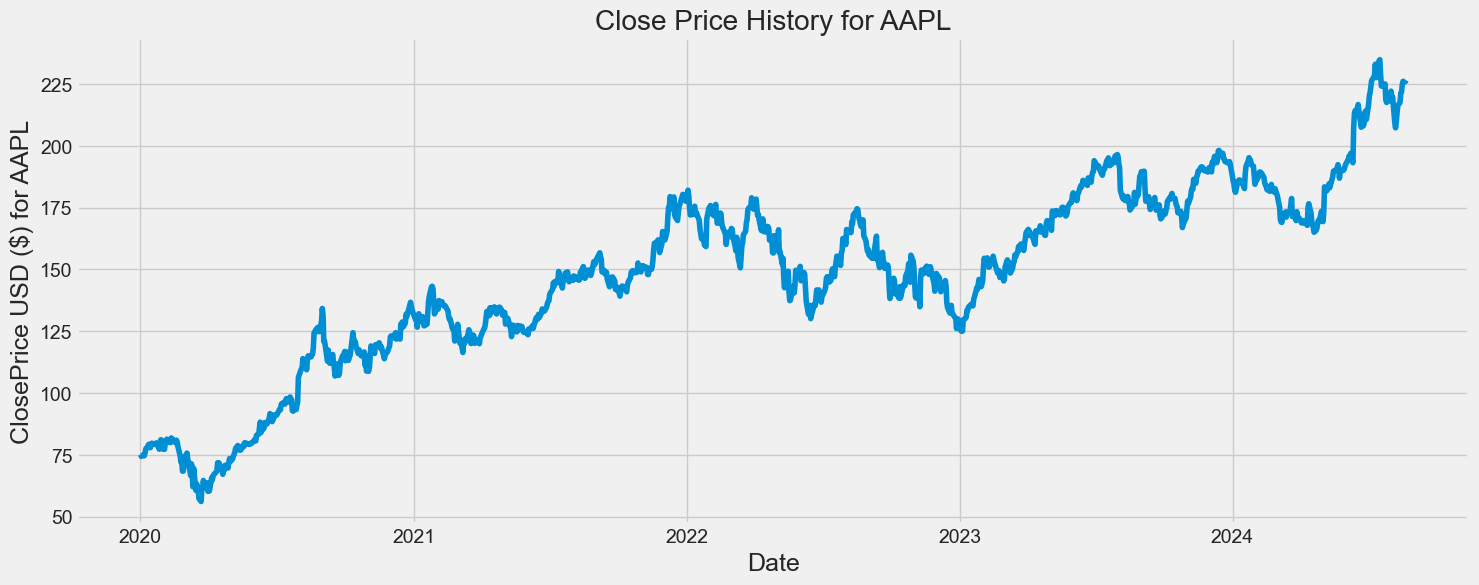

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - loss: 0.0058
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step


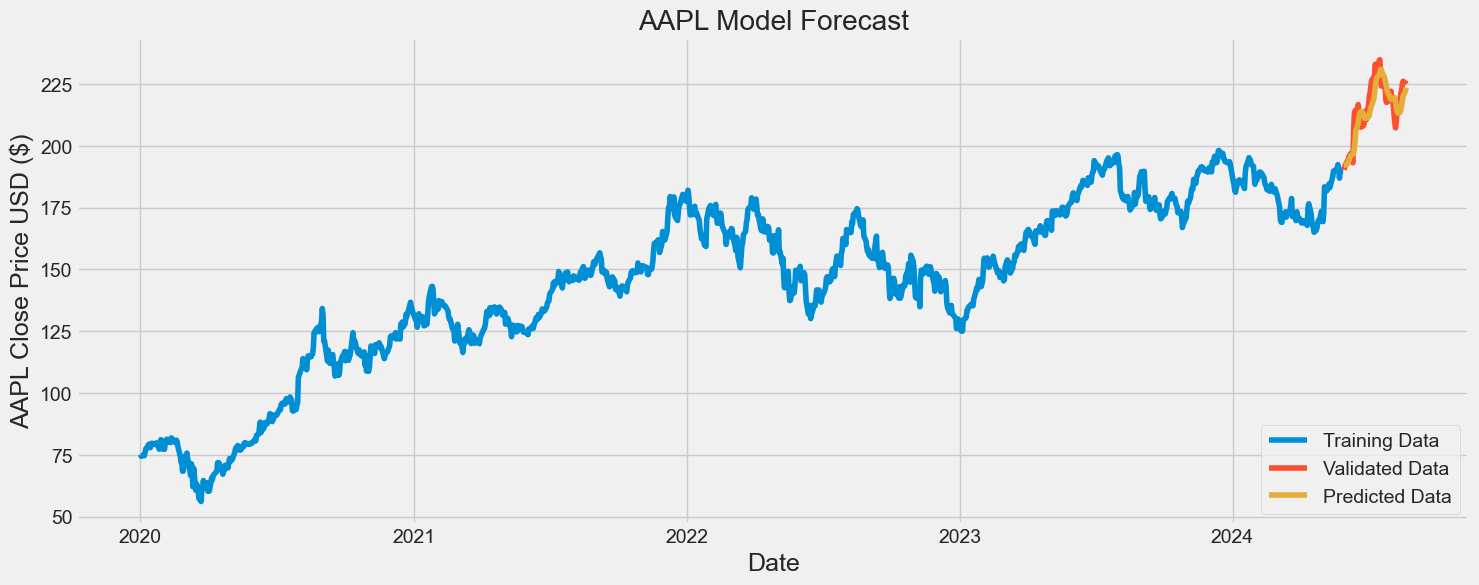

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 5.682


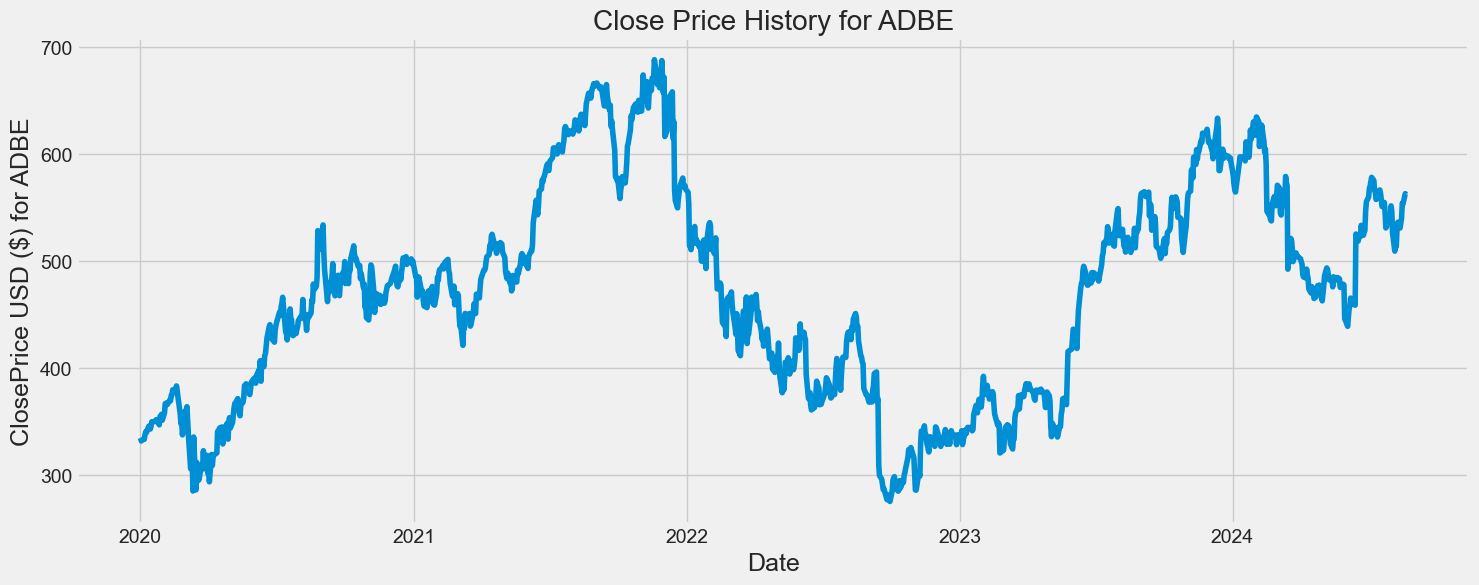

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - loss: 0.0113
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step


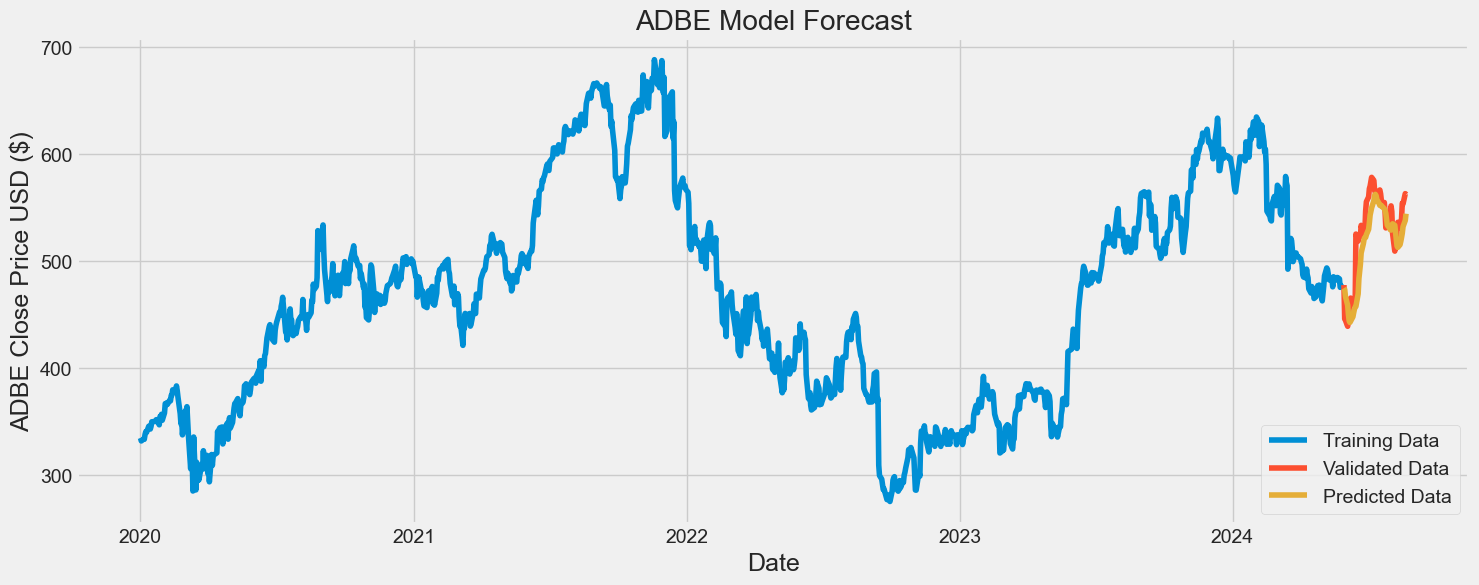

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 20.591


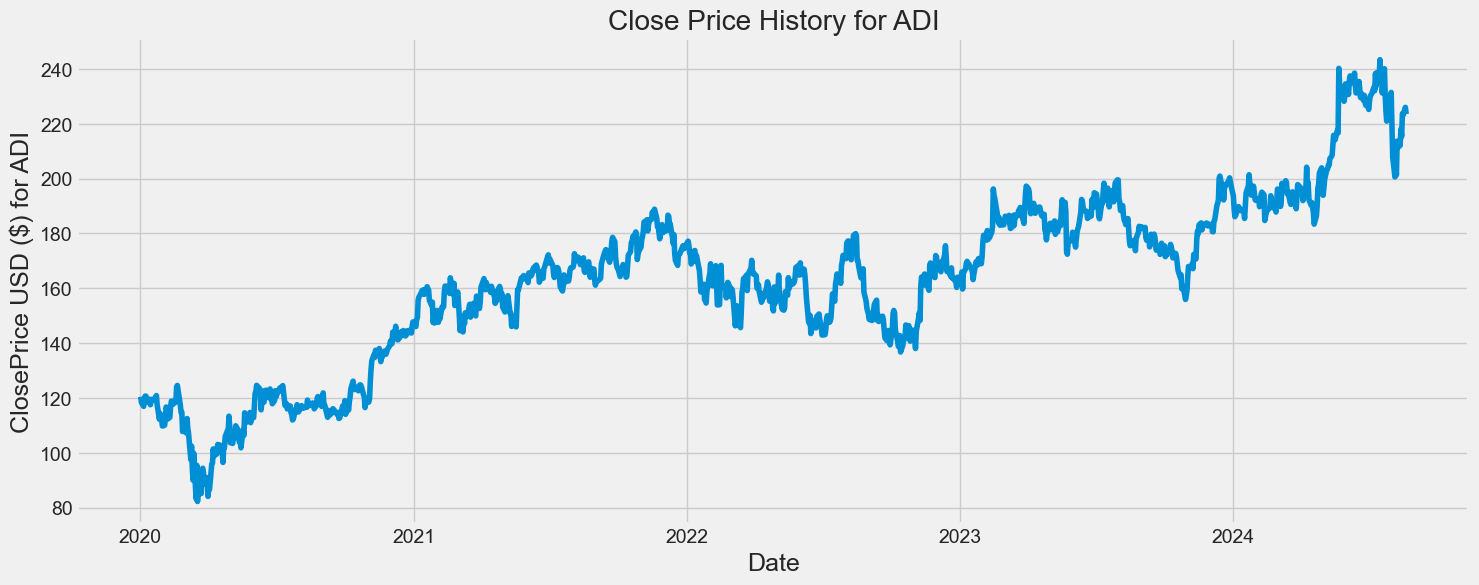

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - loss: 0.0052
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step


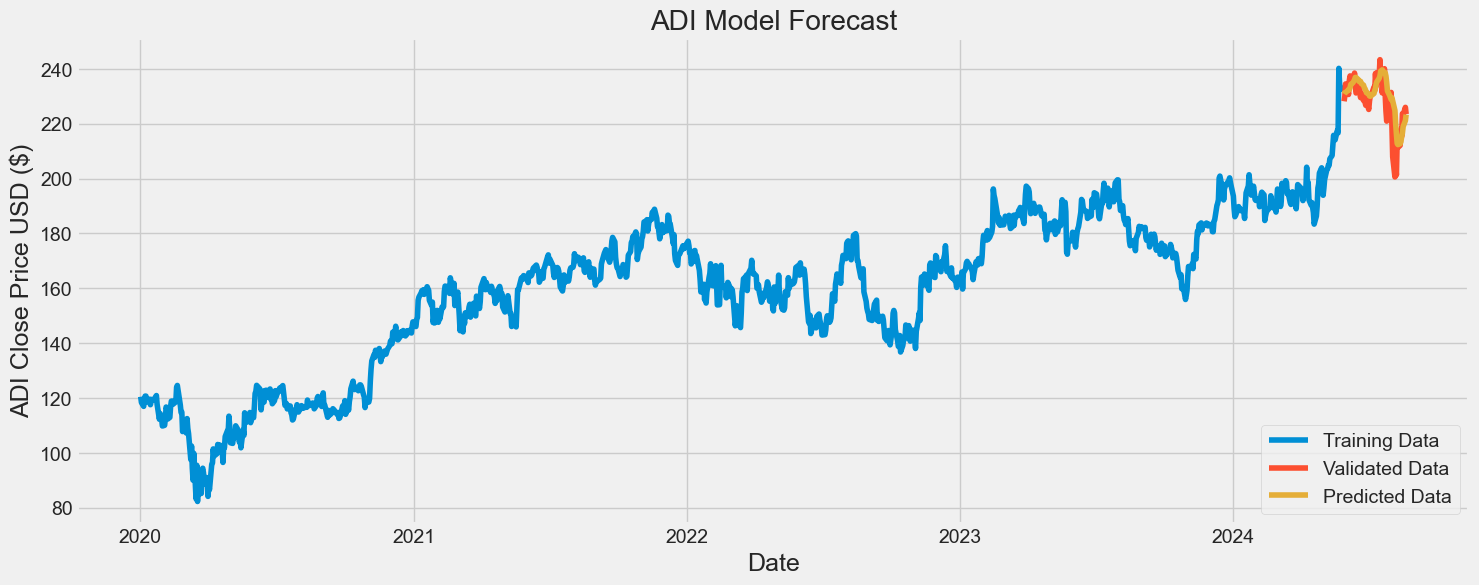

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 6.739


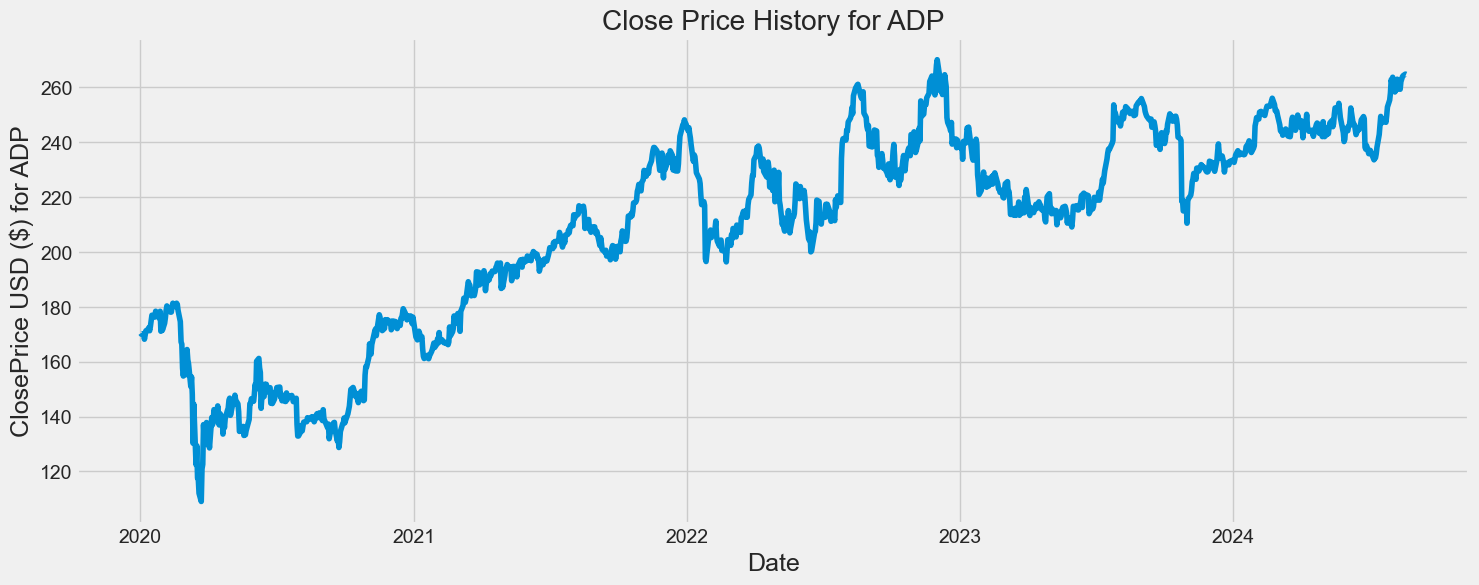

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - loss: 0.0073
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step


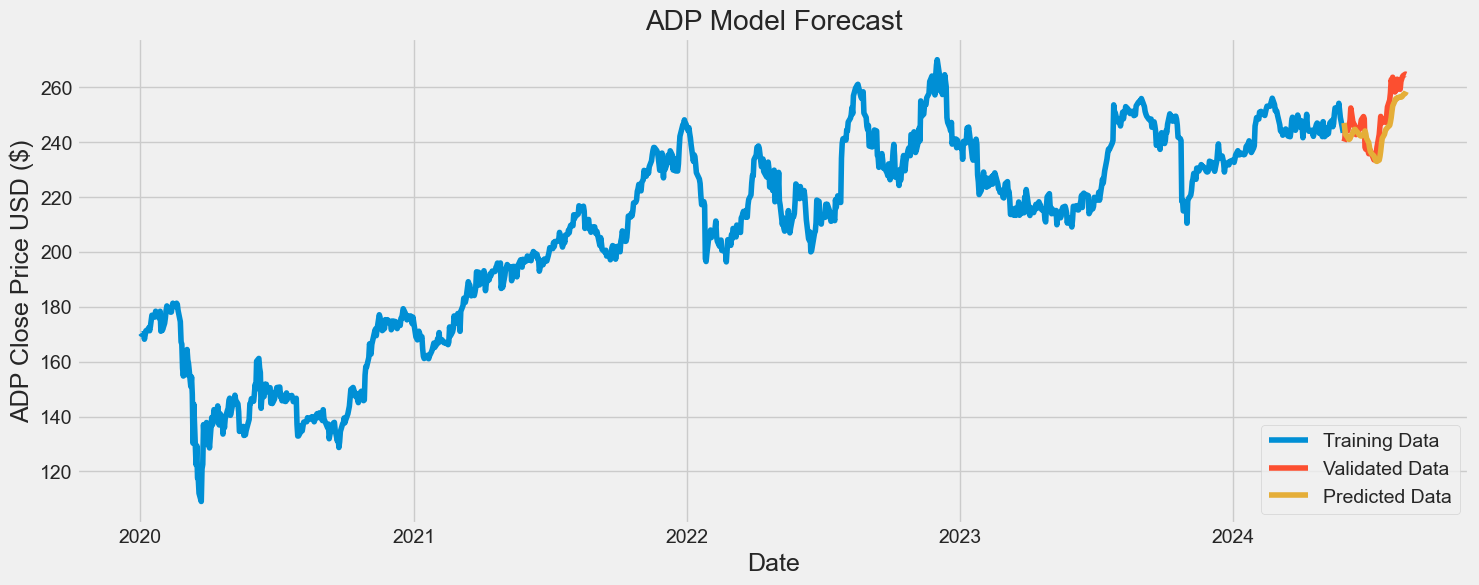

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 6.080


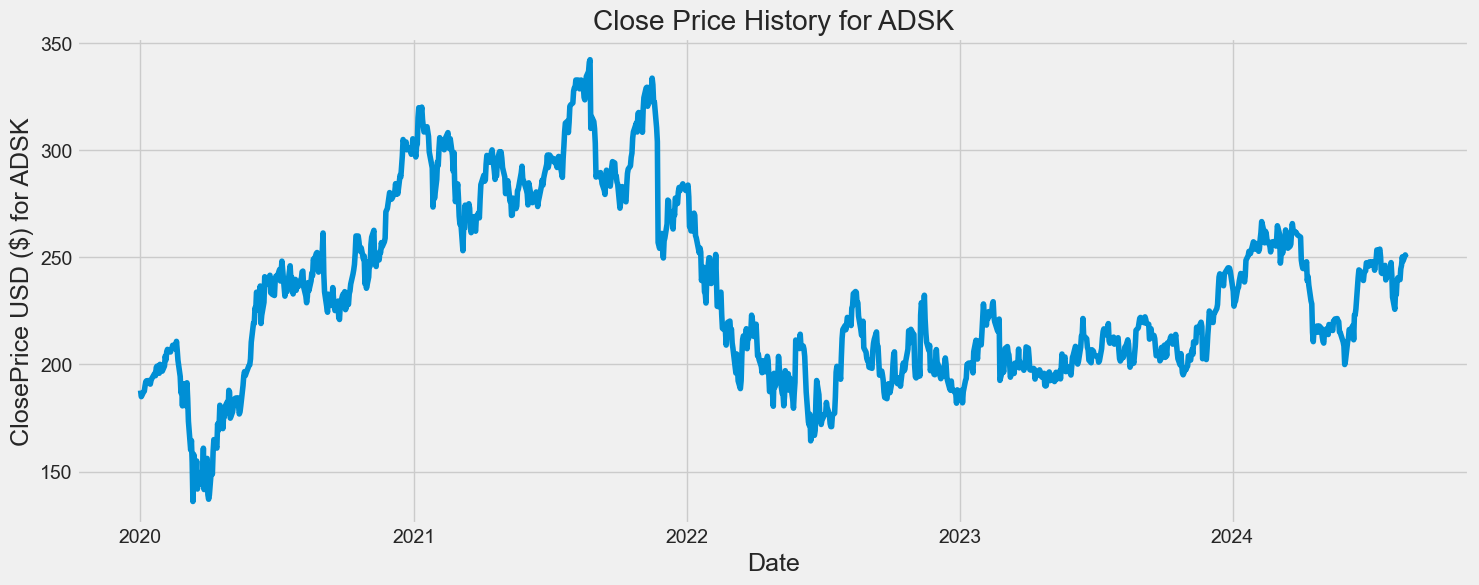

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 0.0107
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 371ms/step


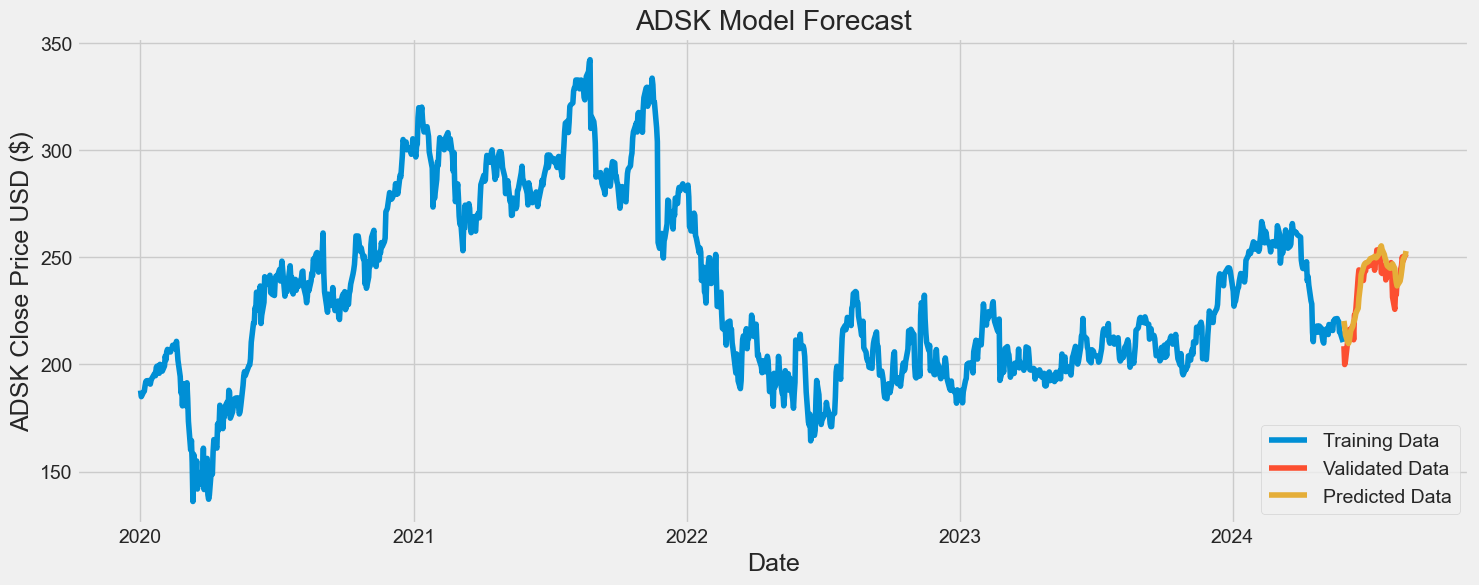

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 6.701


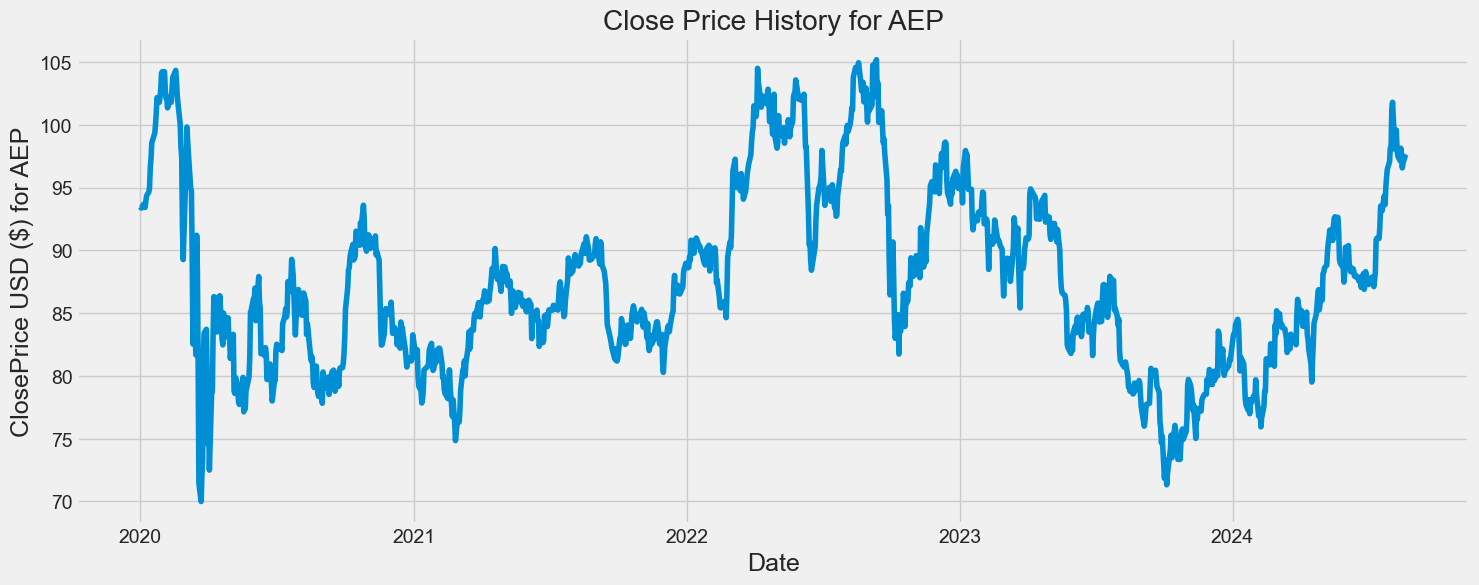

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 0.0085
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 394ms/step


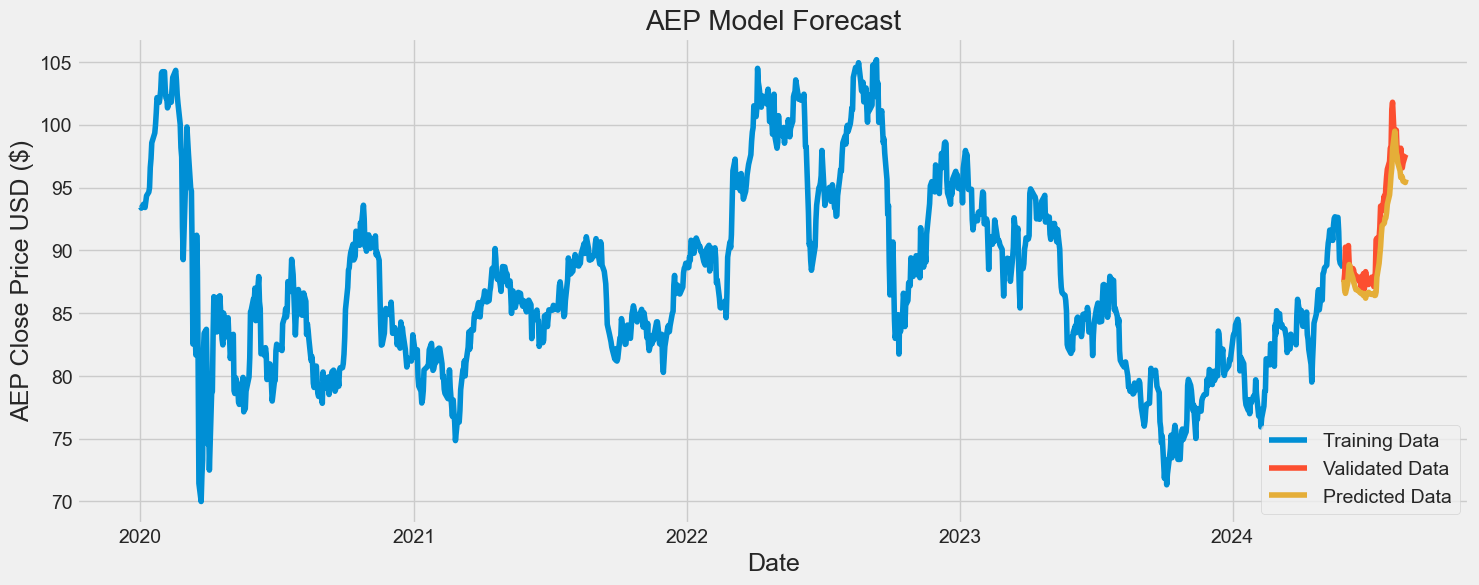

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 1.930


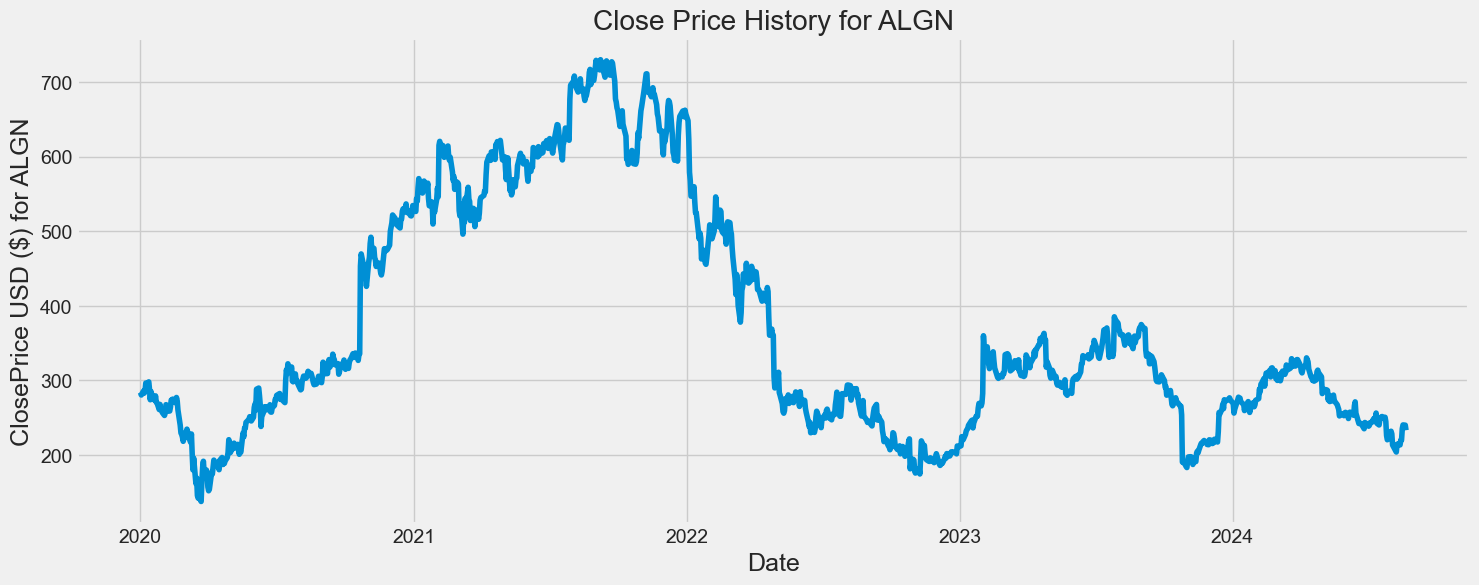

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - loss: 0.0082
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 470ms/step


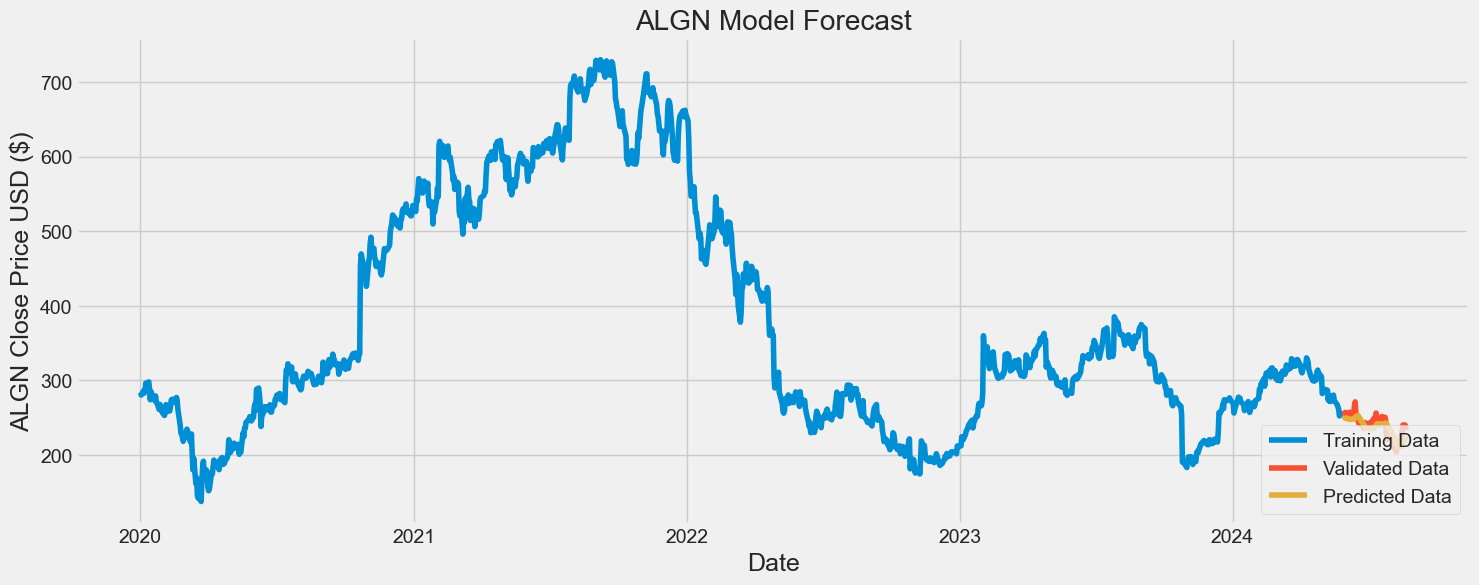

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 10.145


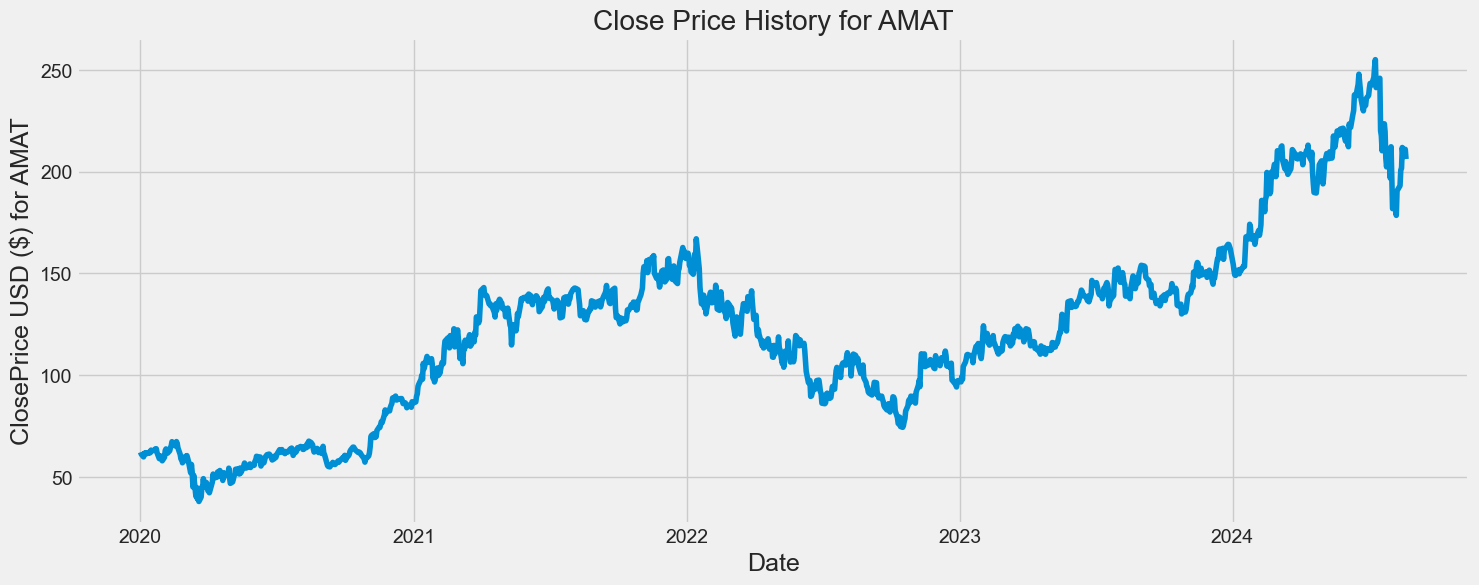

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - loss: 0.0052
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


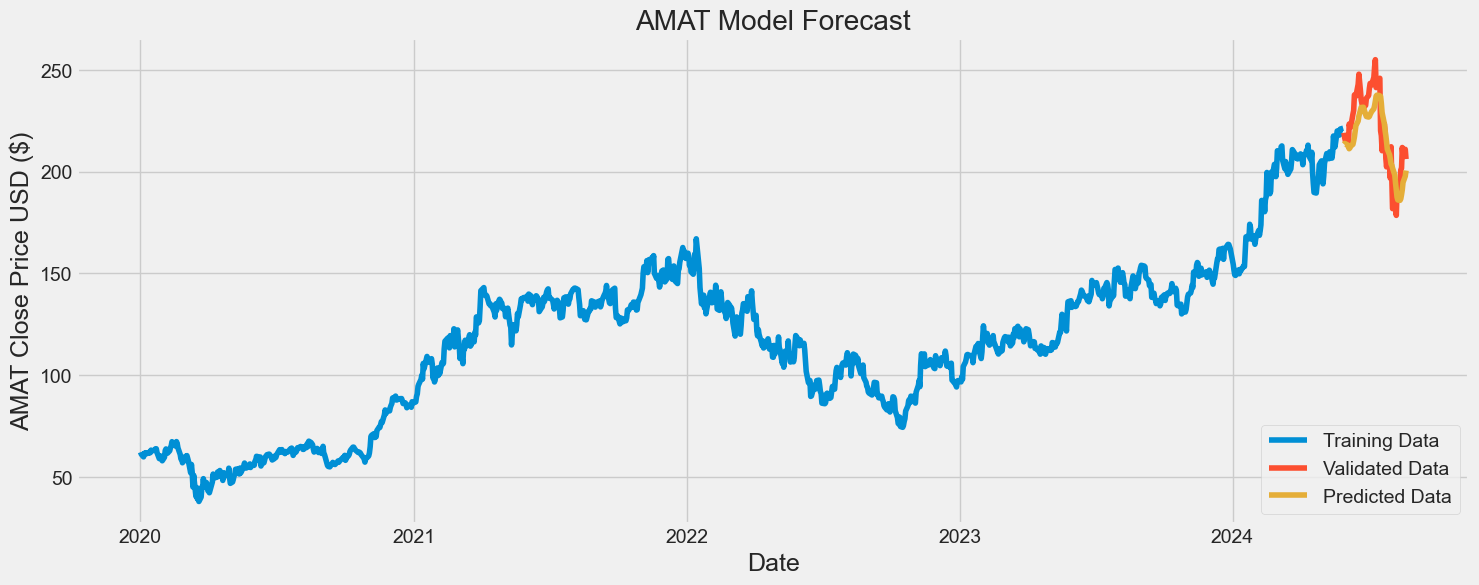

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 11.946


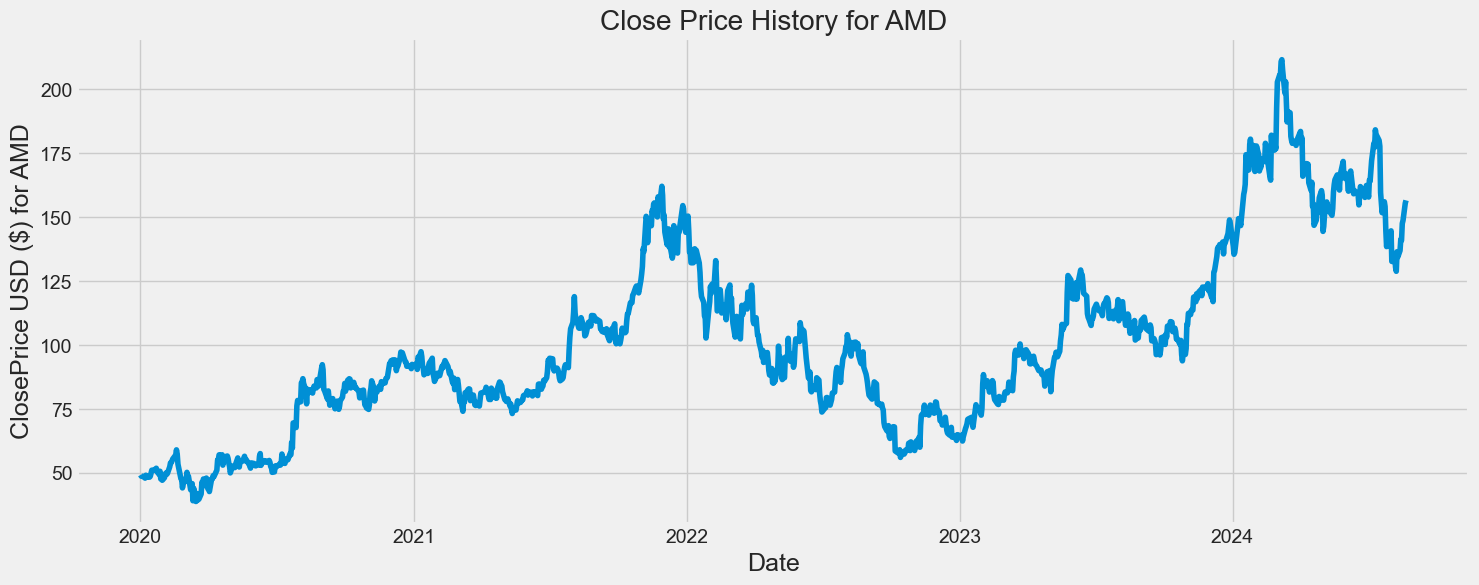

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - loss: 0.0048
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 434ms/step


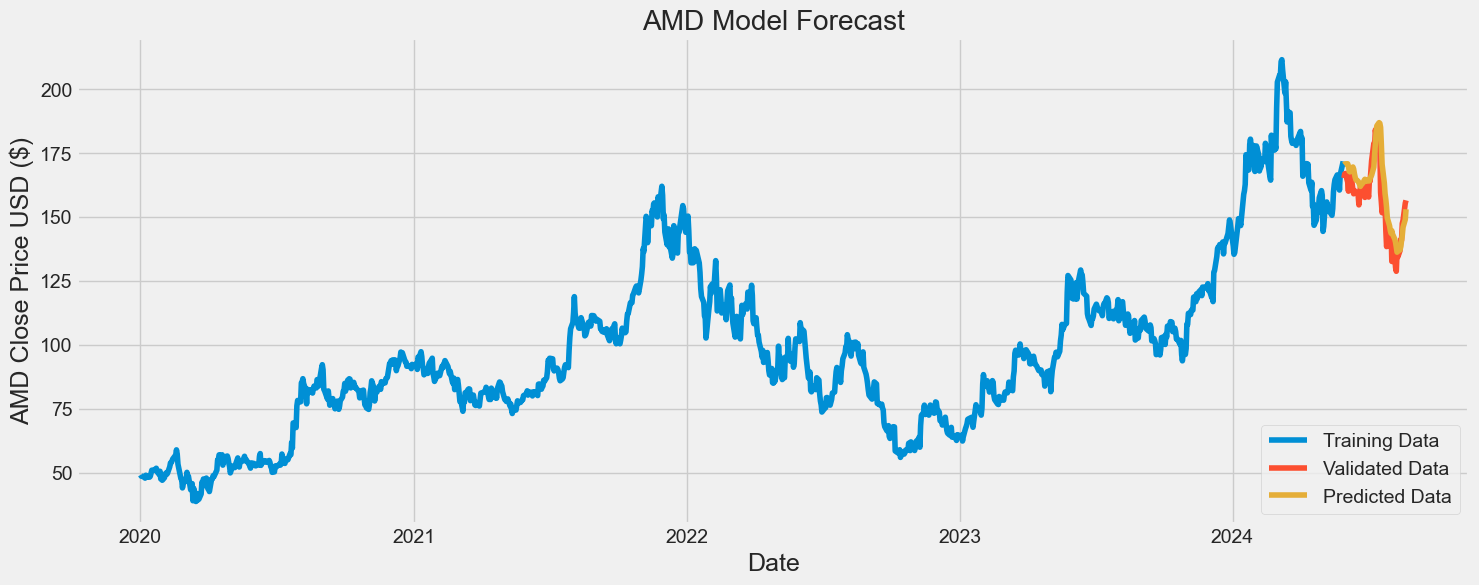

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 8.057


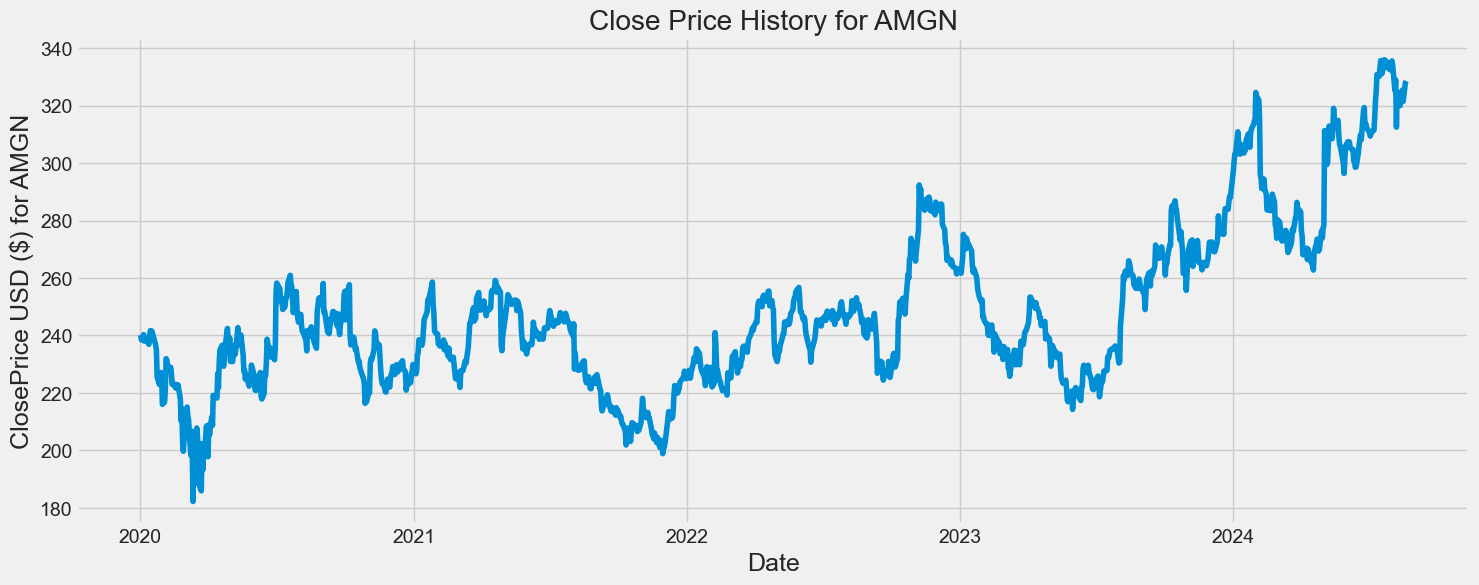

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - loss: 0.0059
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 495ms/step


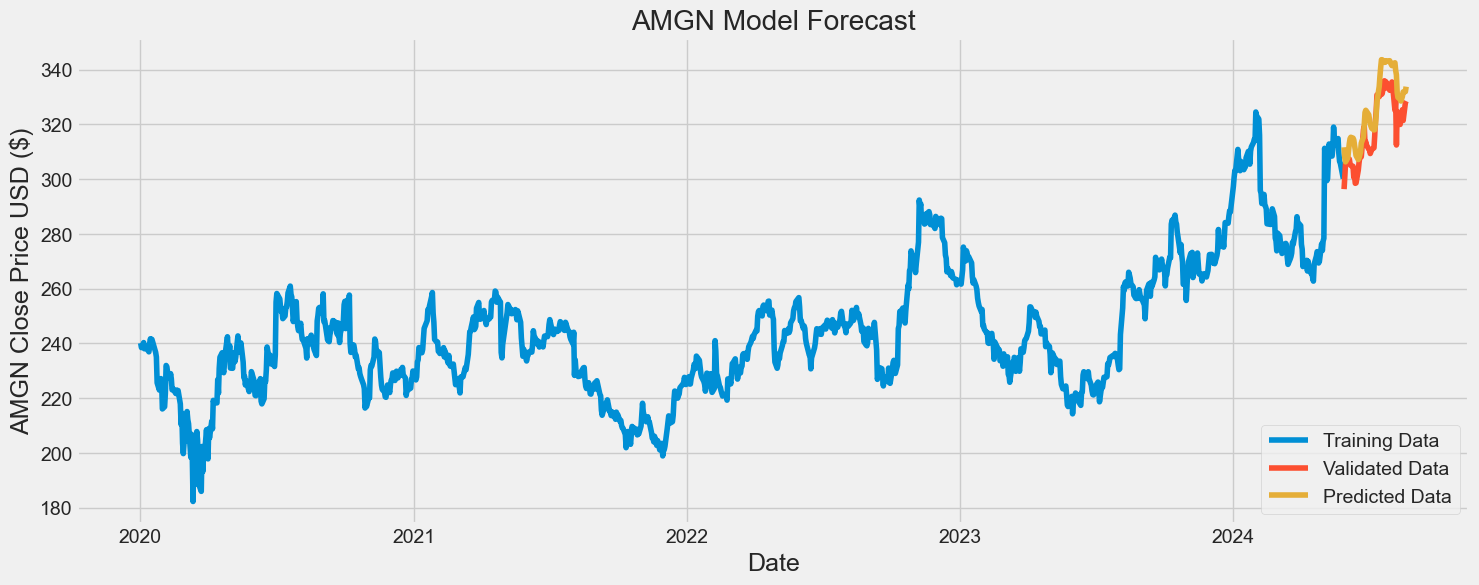

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 9.087


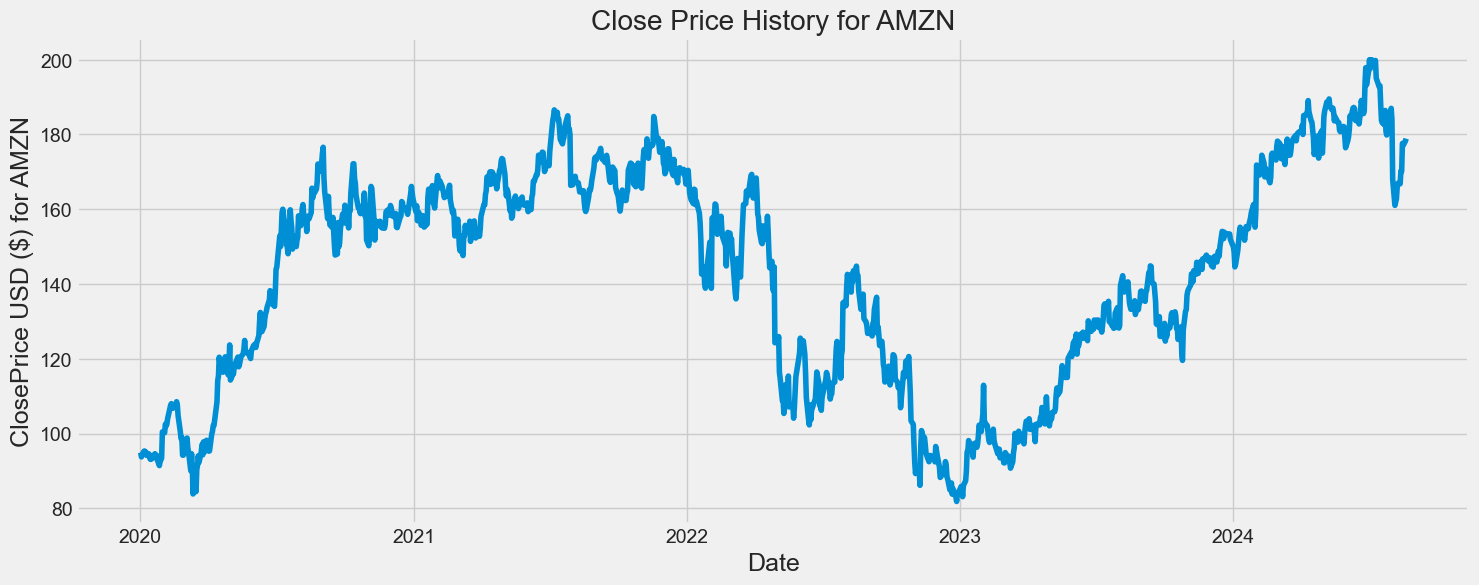

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - loss: 0.0082
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


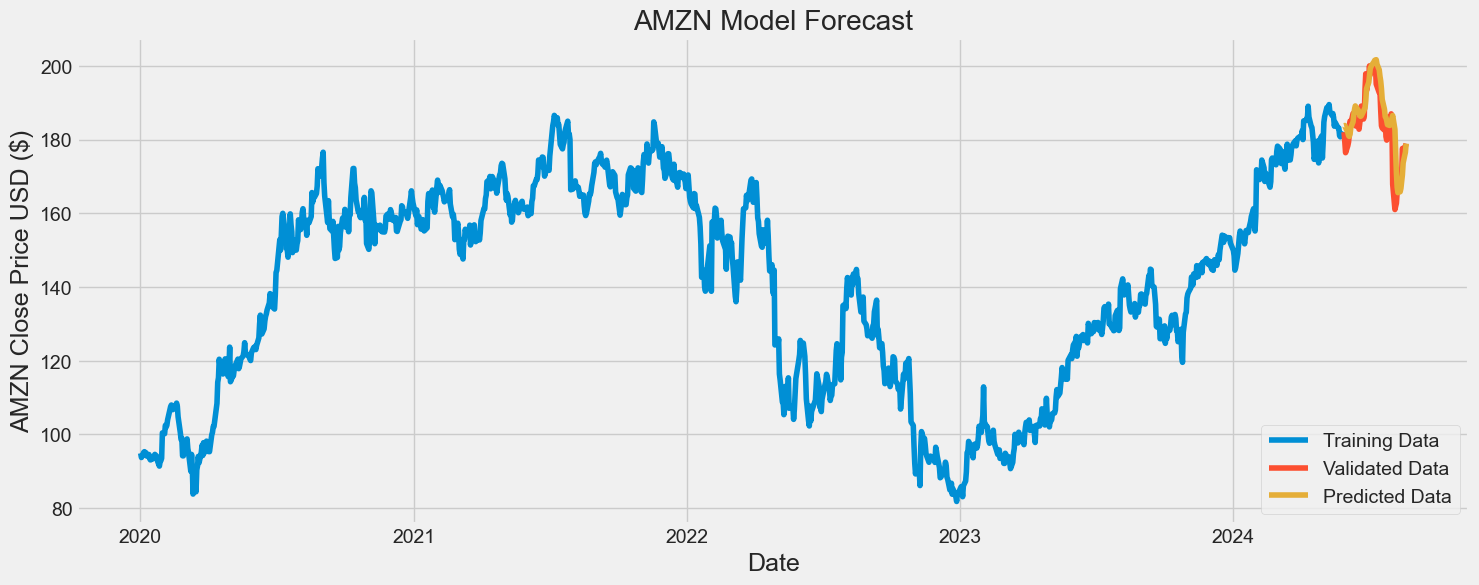

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 5.813


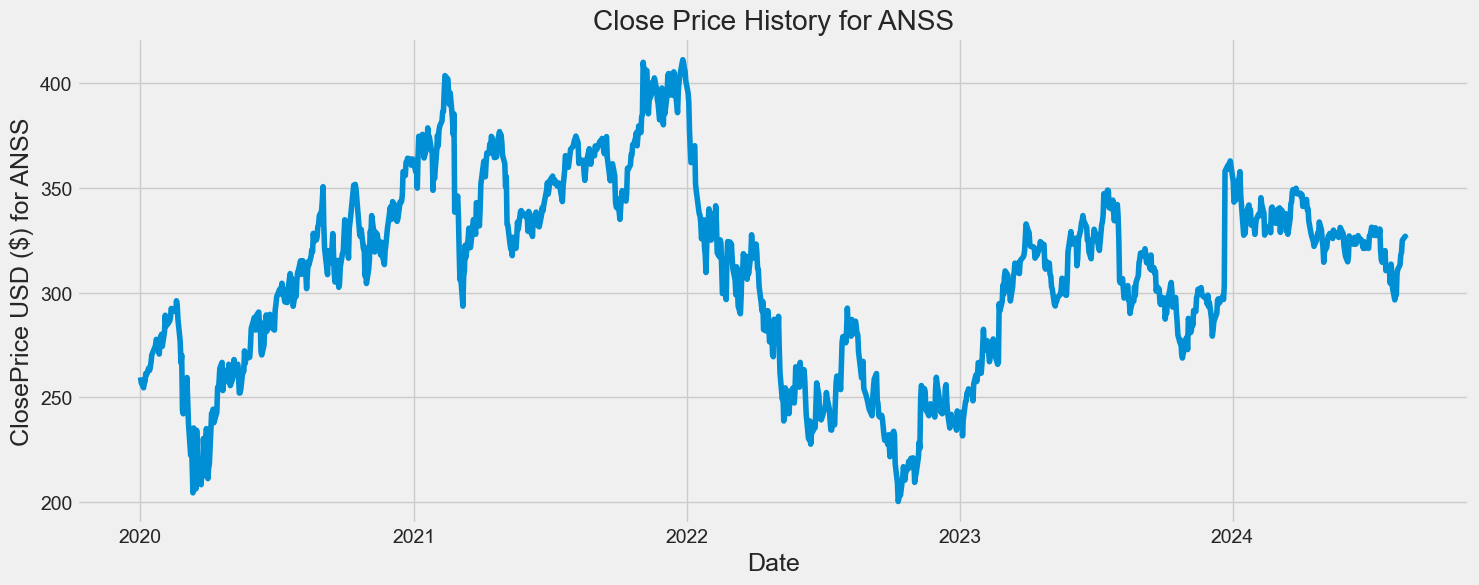

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - loss: 0.0096
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 479ms/step


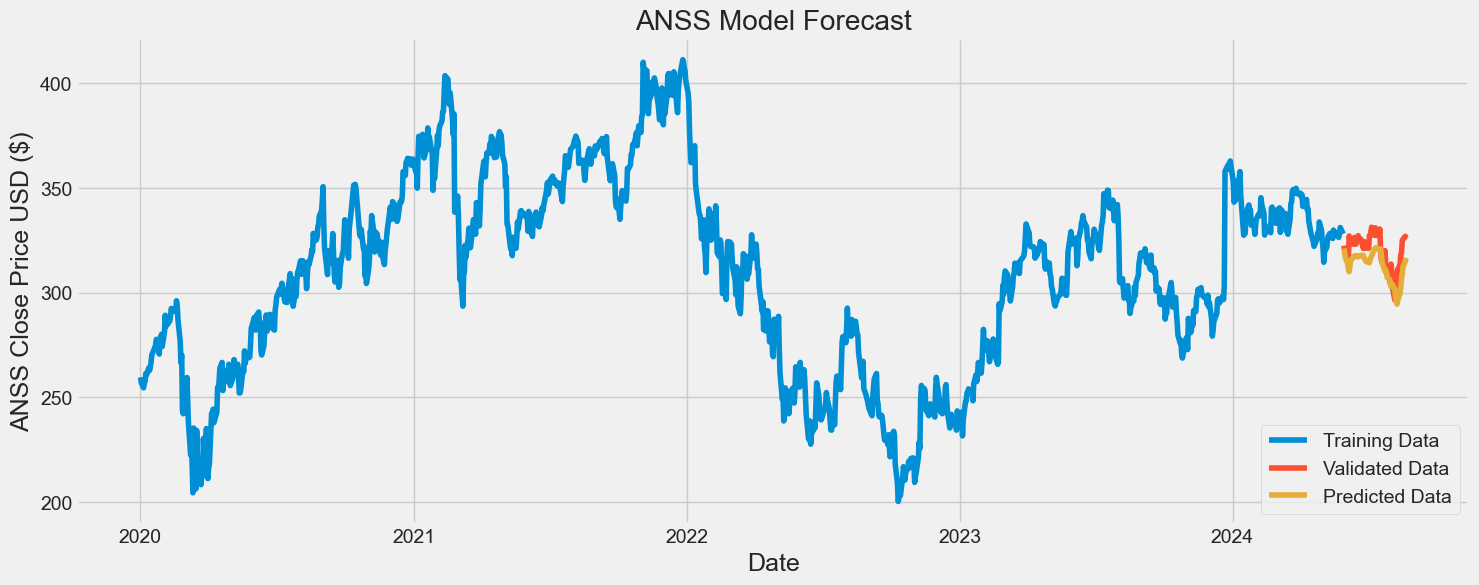

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 8.632


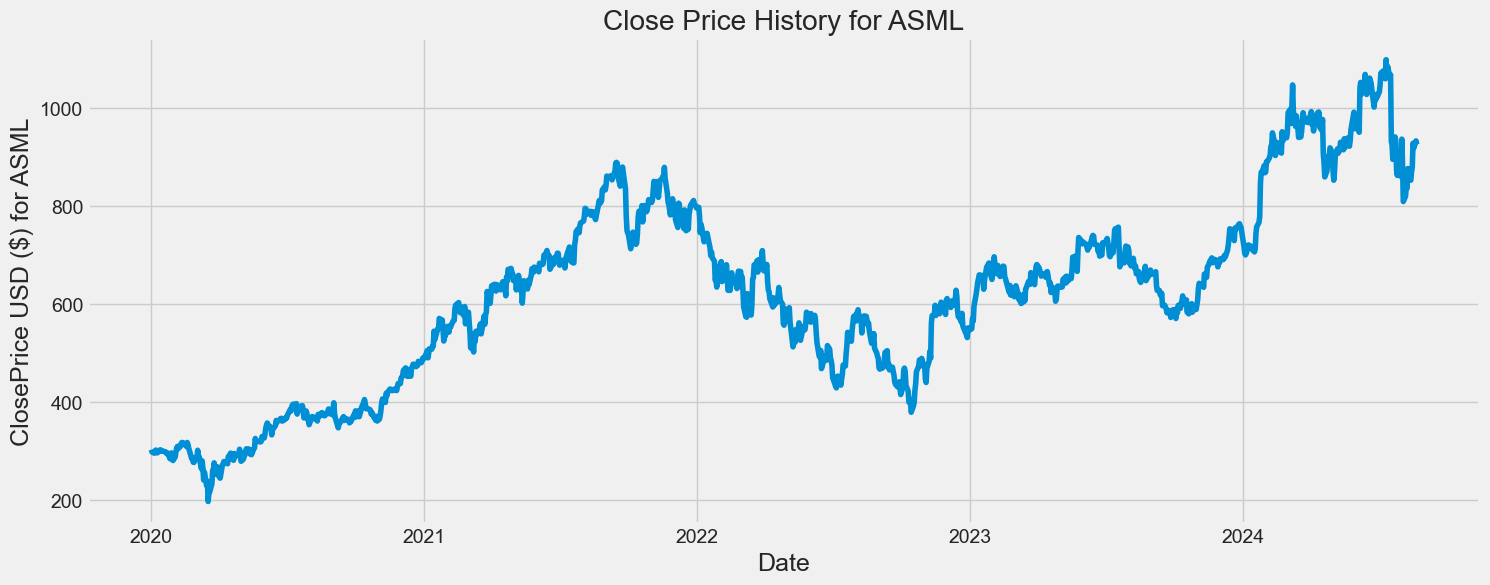

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - loss: 0.0106
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step


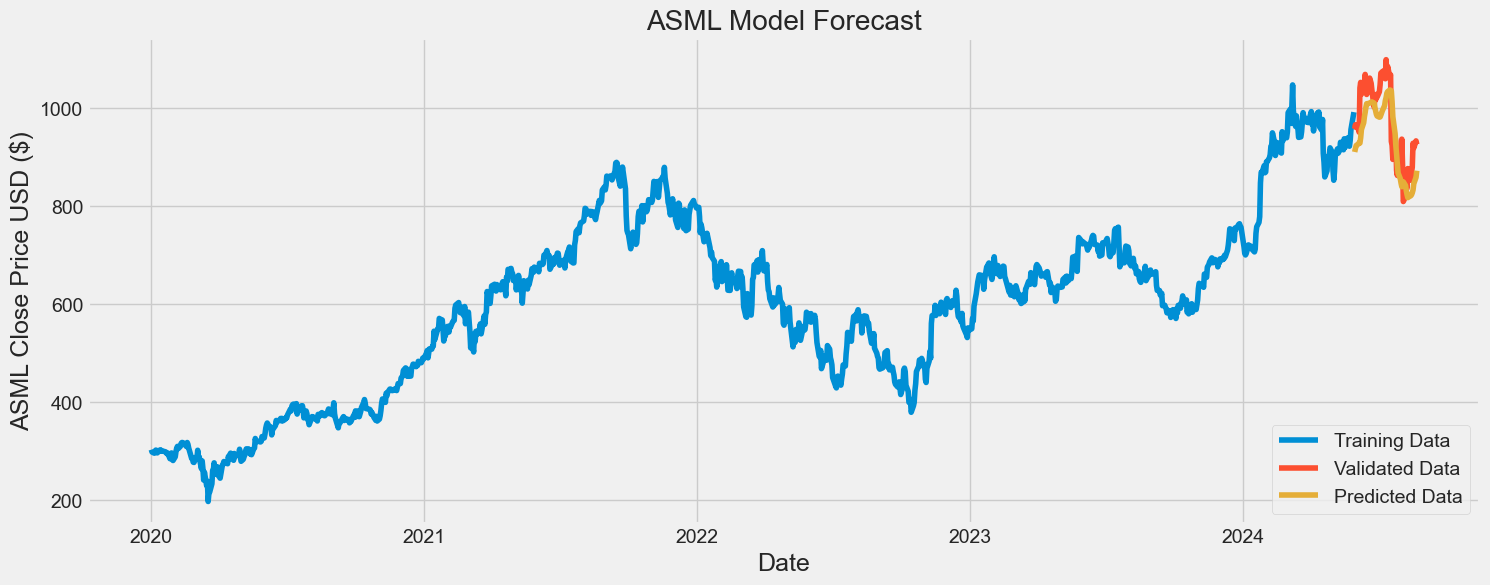

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 55.907


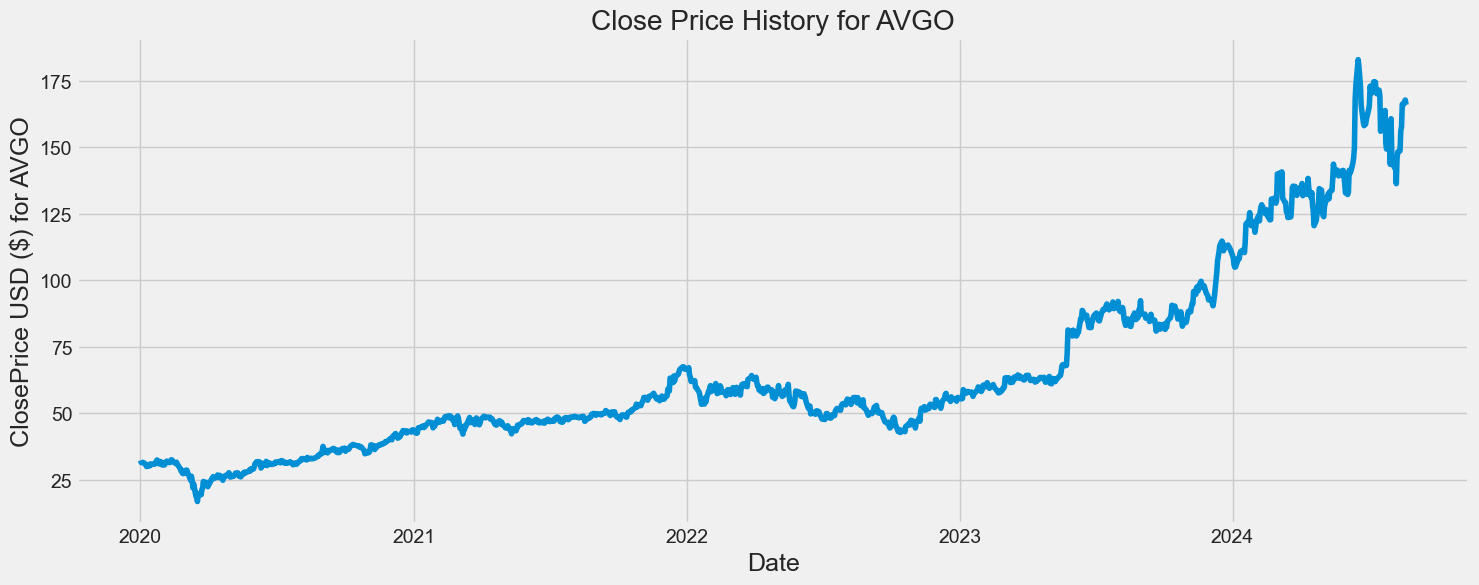

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 34s 29ms/step - loss: 0.0036
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 449ms/step


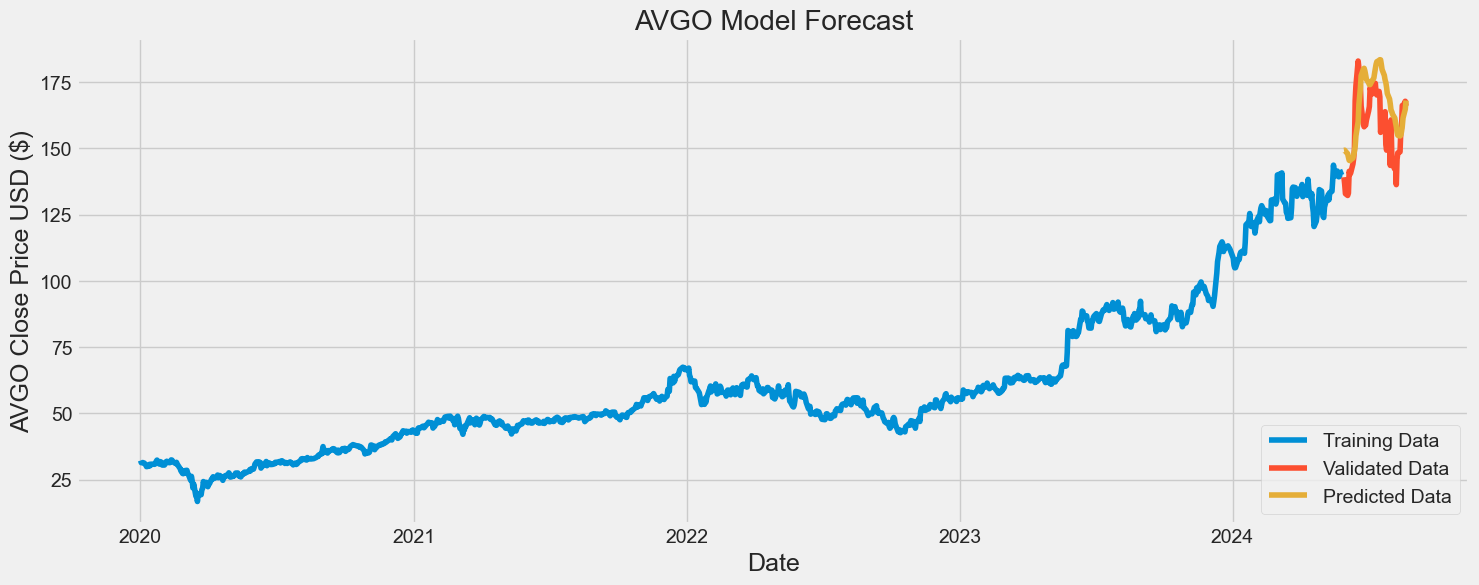

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 14.257


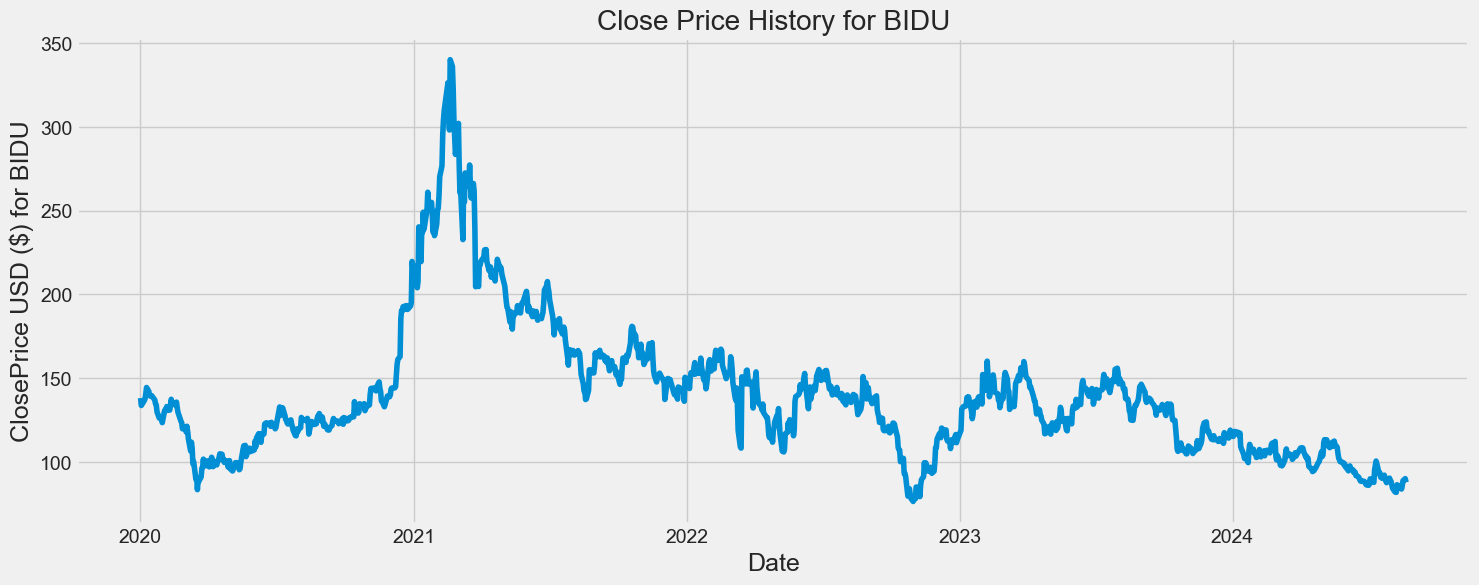

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - loss: 0.0060
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step


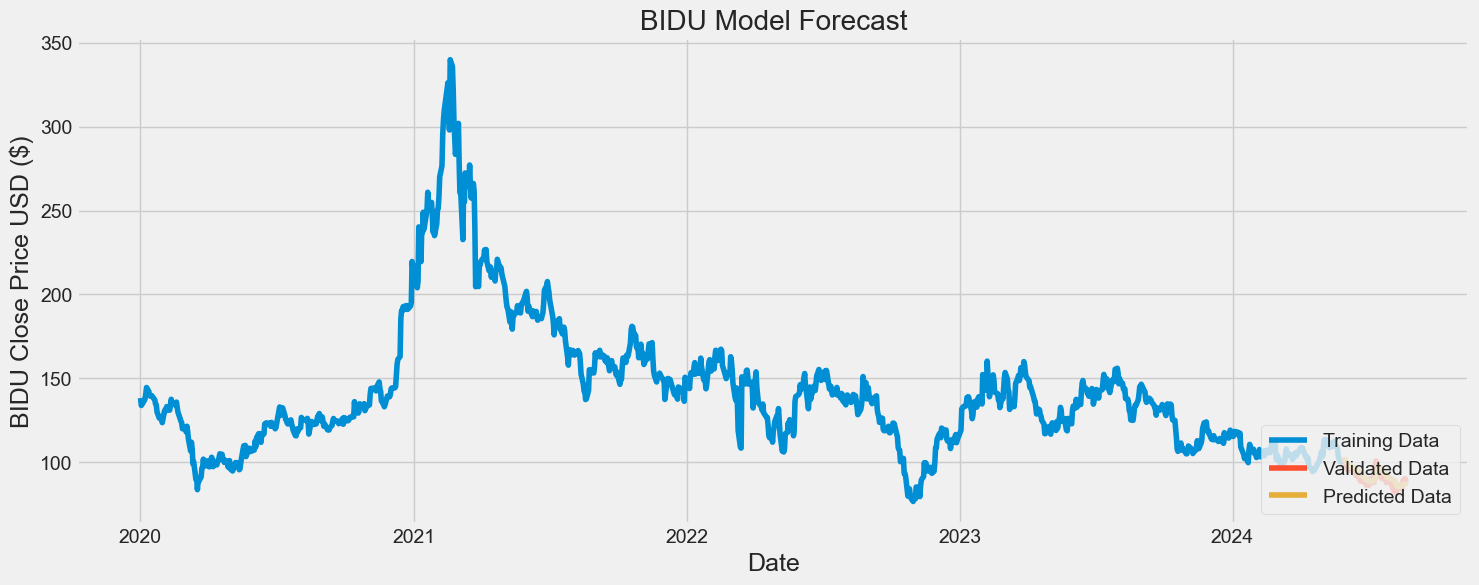

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 3.466


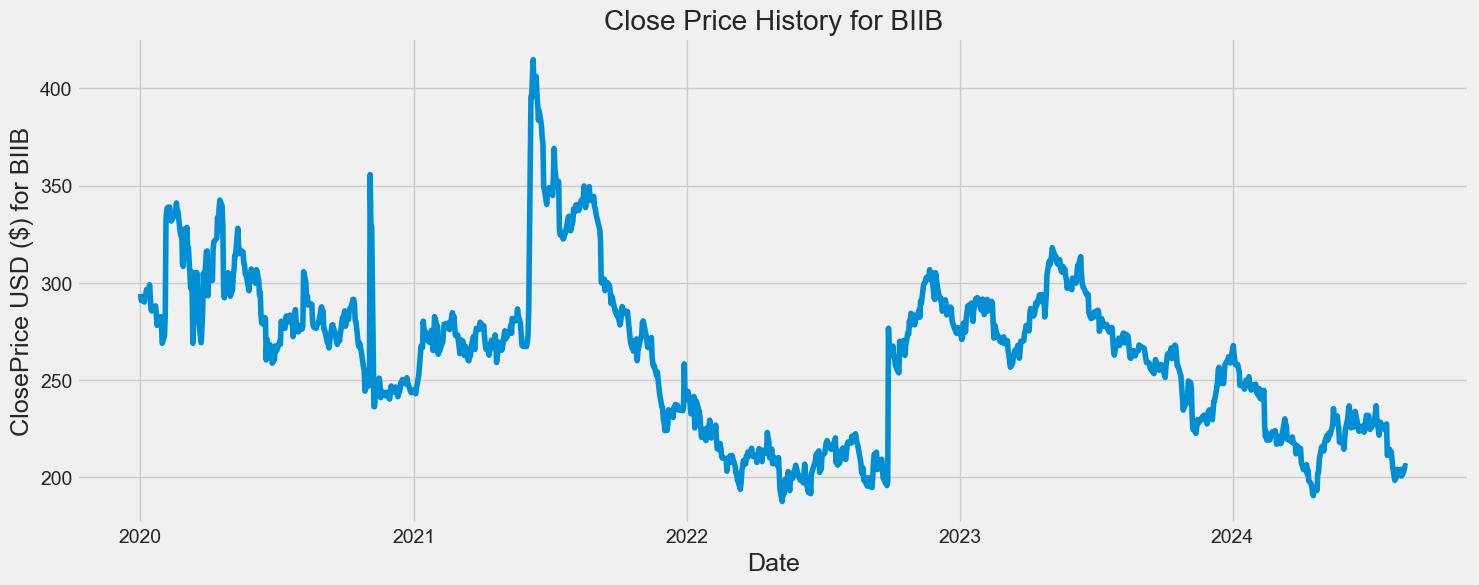

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - loss: 0.0075
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


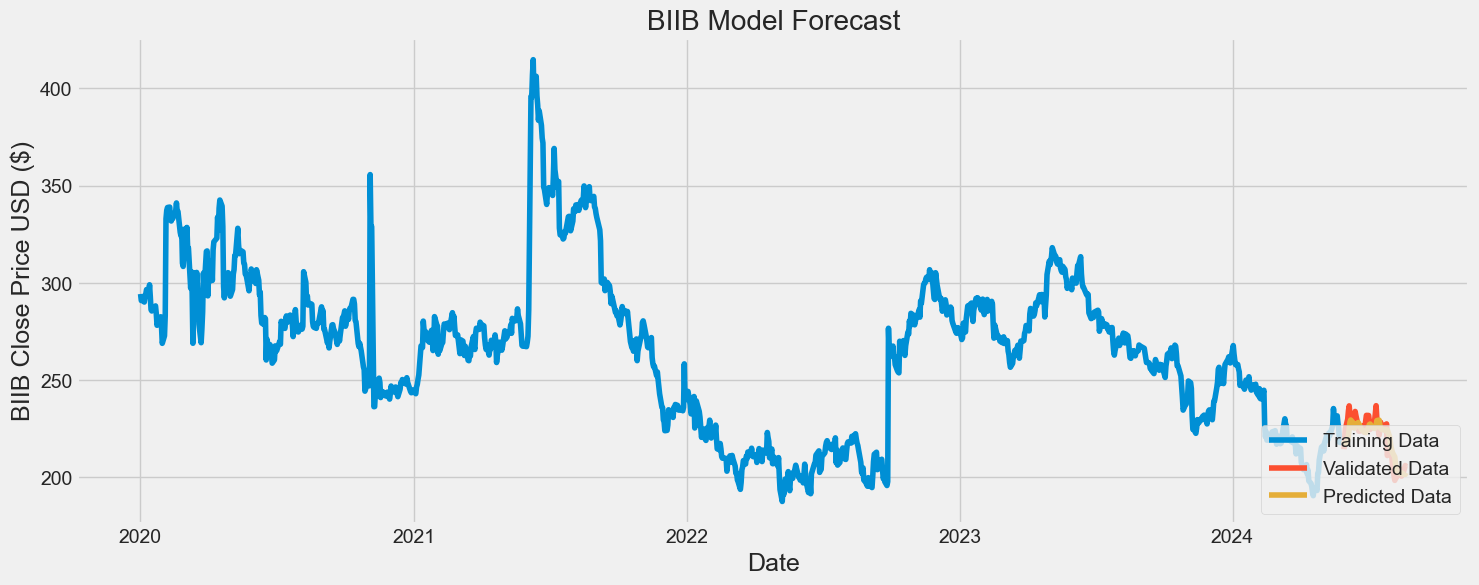

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 5.385


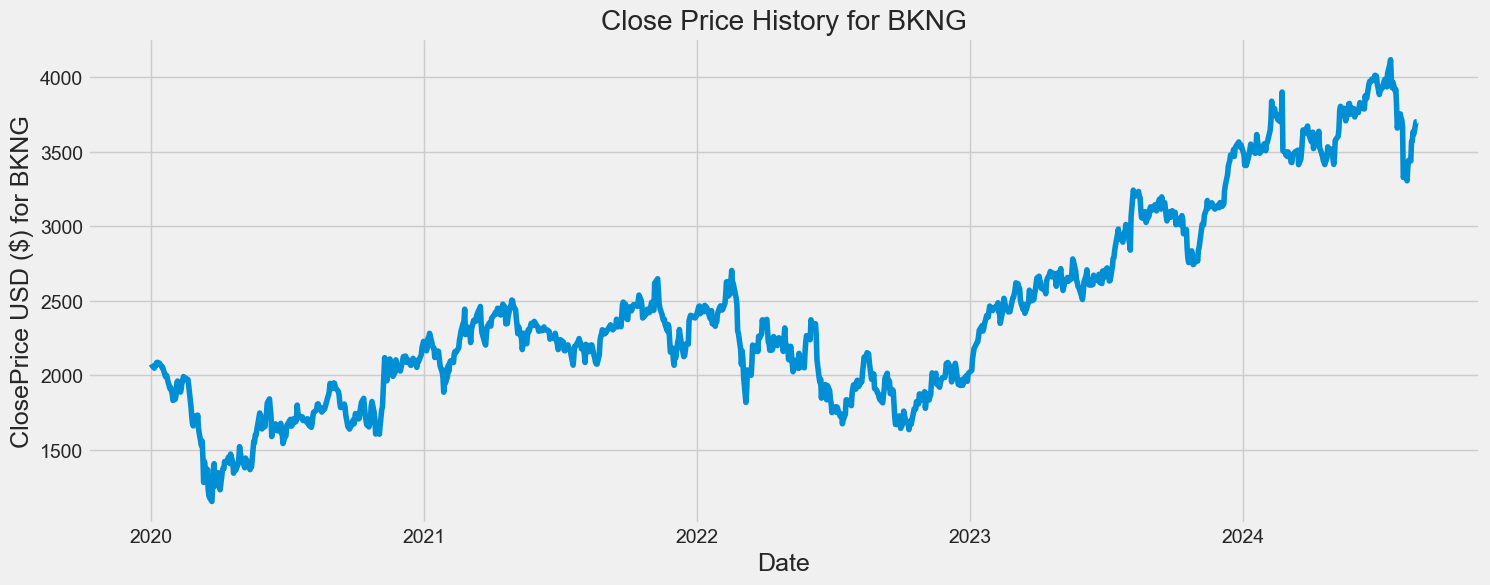

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - loss: 0.0055
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 461ms/step


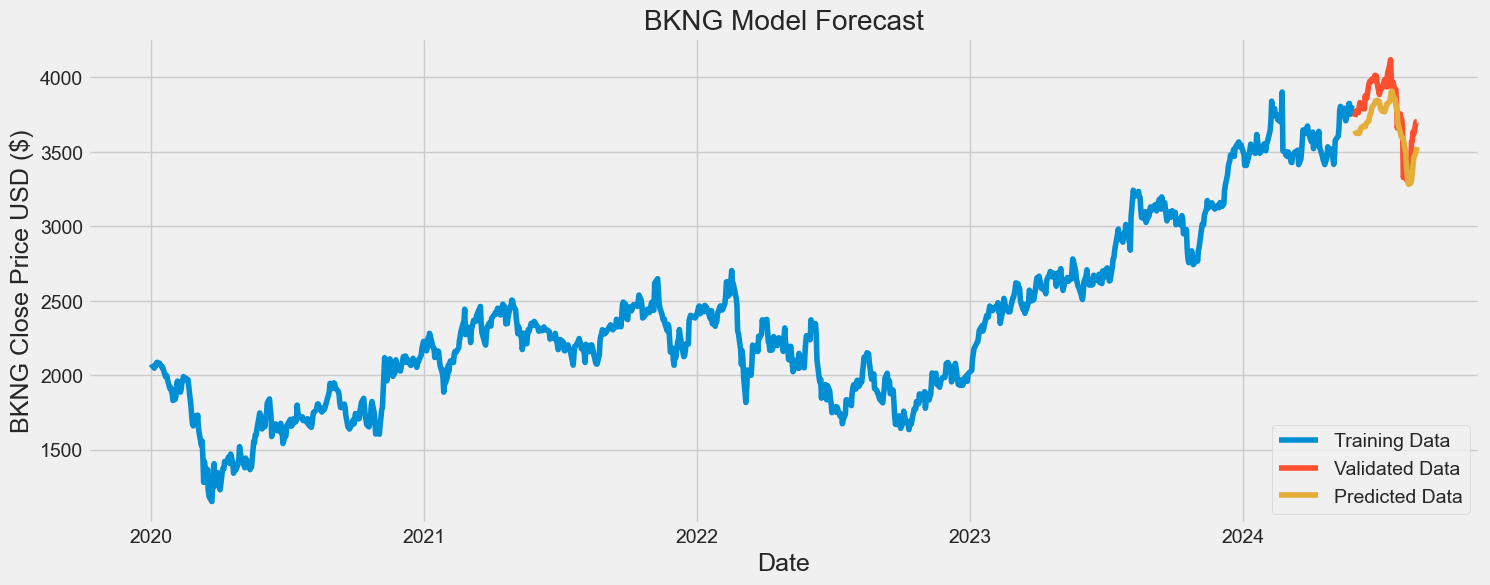

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 158.582


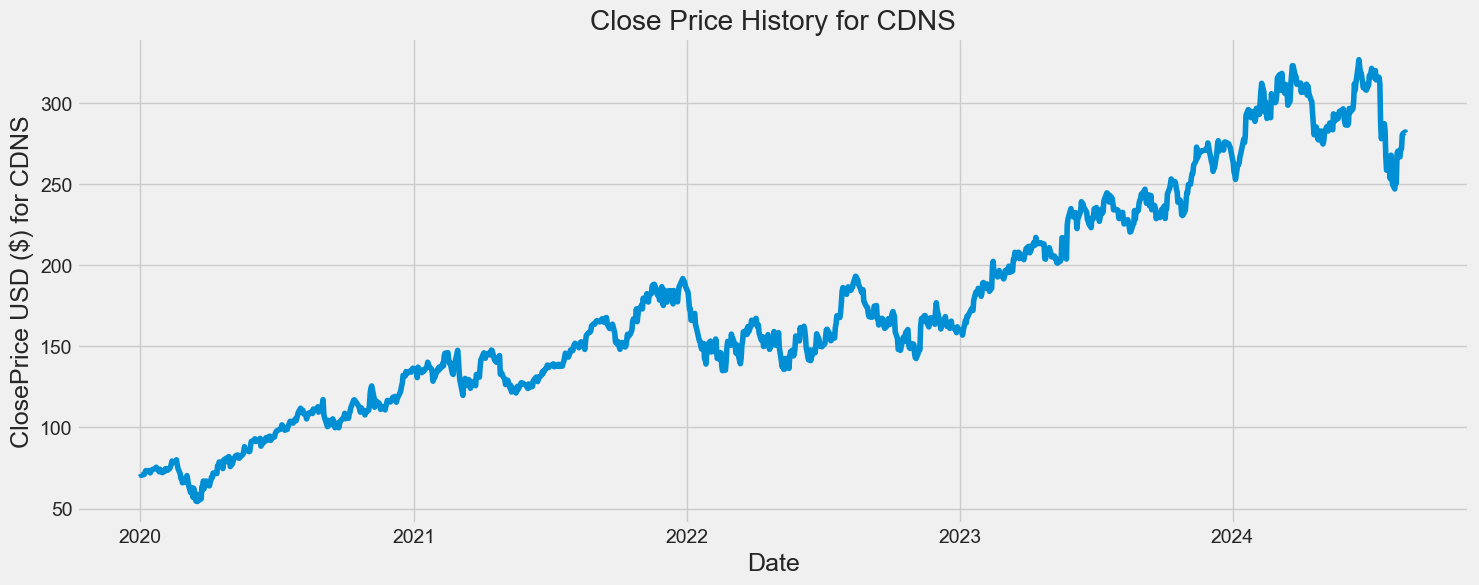

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - loss: 0.0035
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 469ms/step


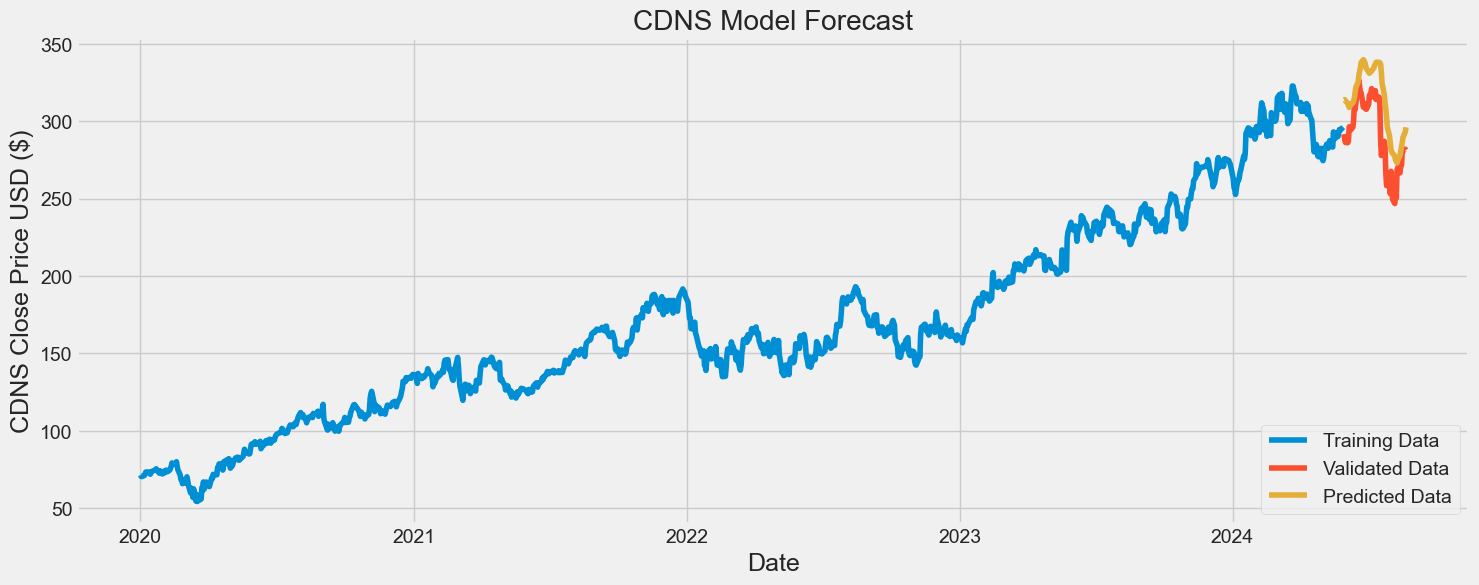

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 24.055


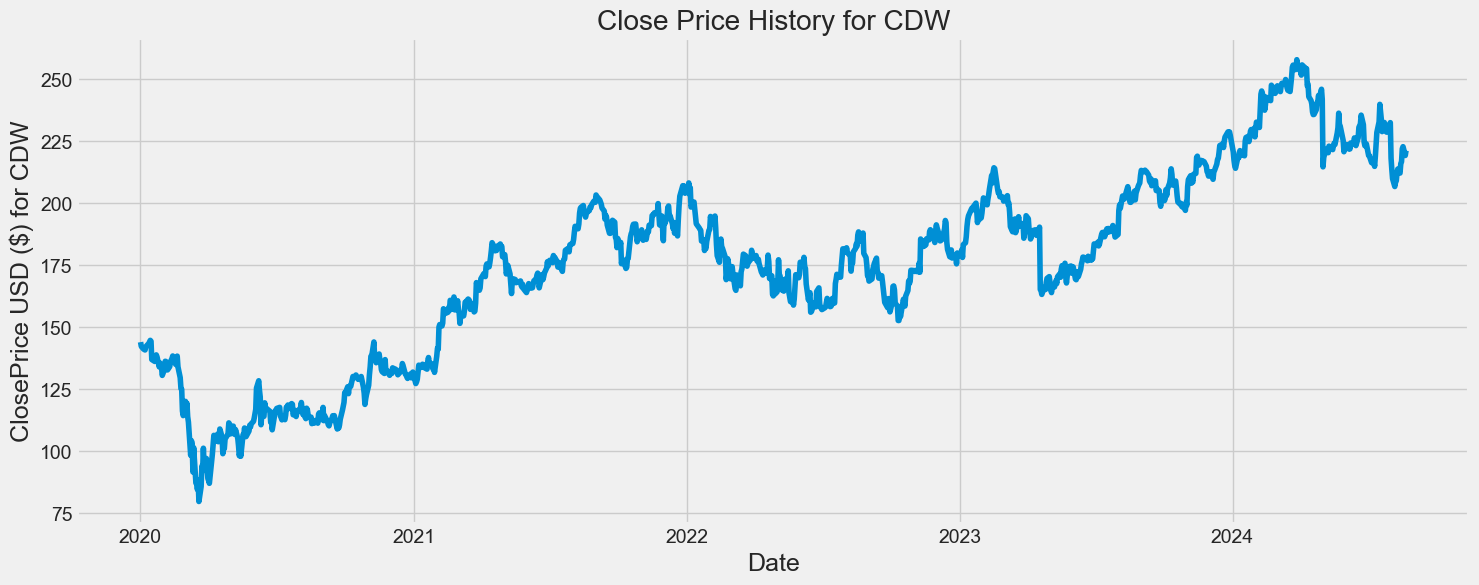

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - loss: 0.0083
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step


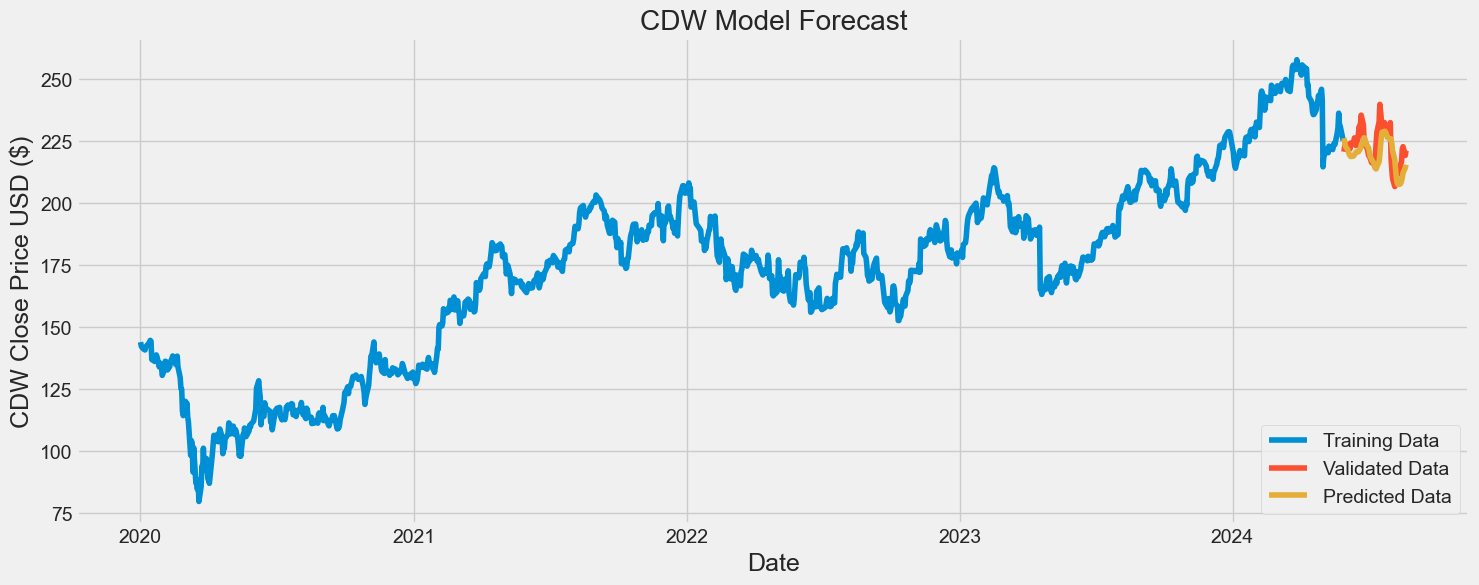

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 7.116


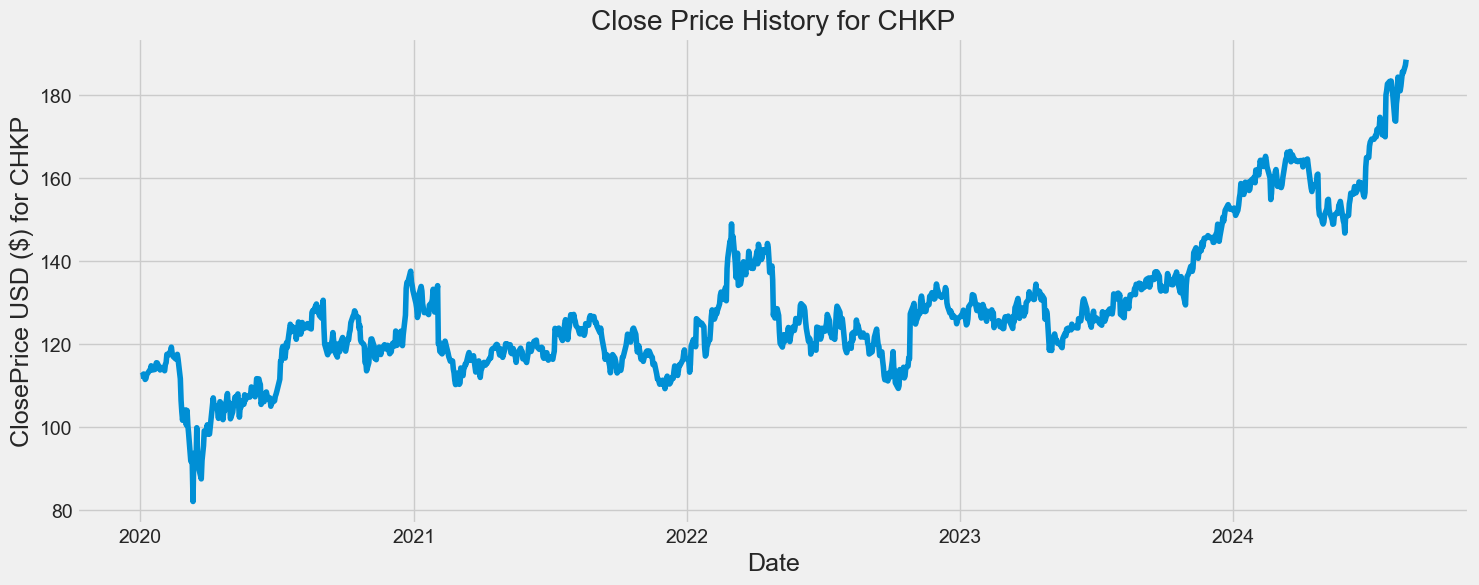

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - loss: 0.0062
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 472ms/step


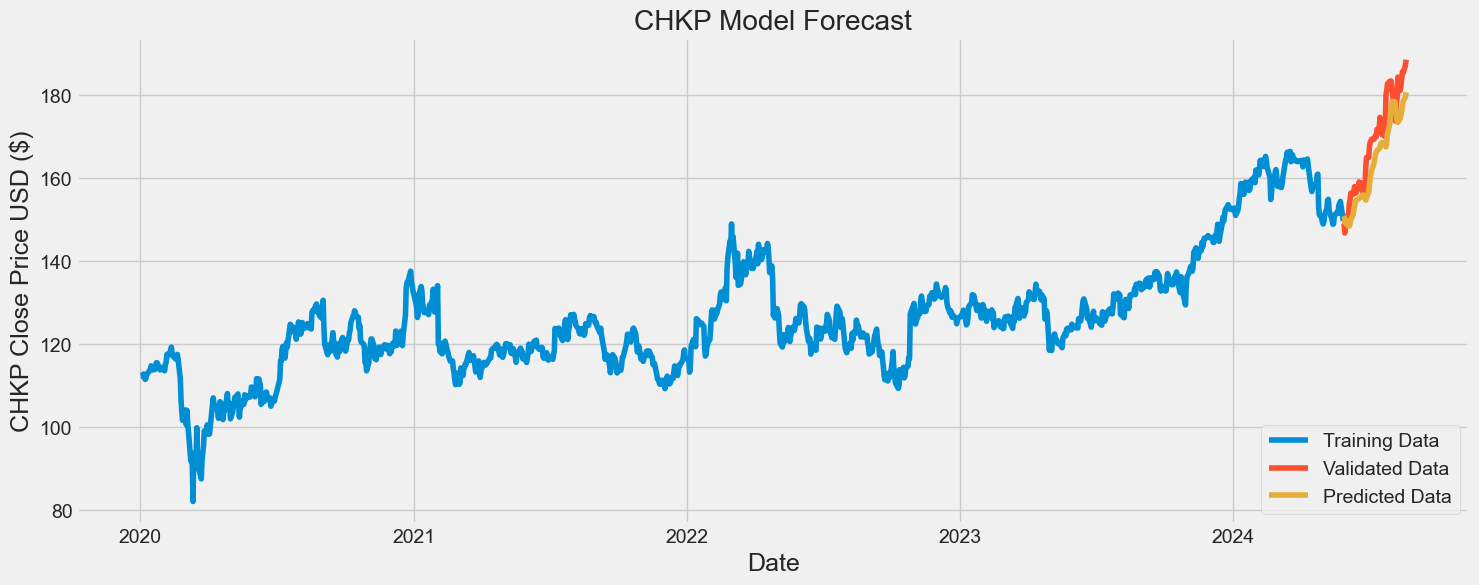

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 6.150


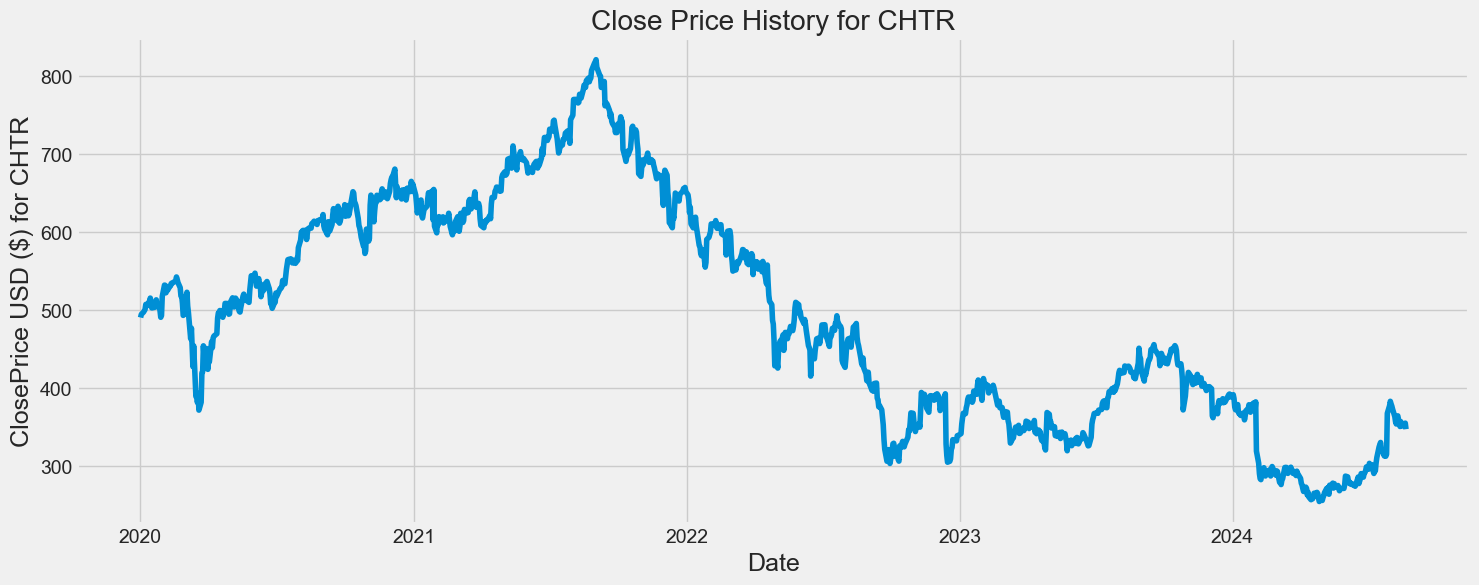

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - loss: 0.0049
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 445ms/step


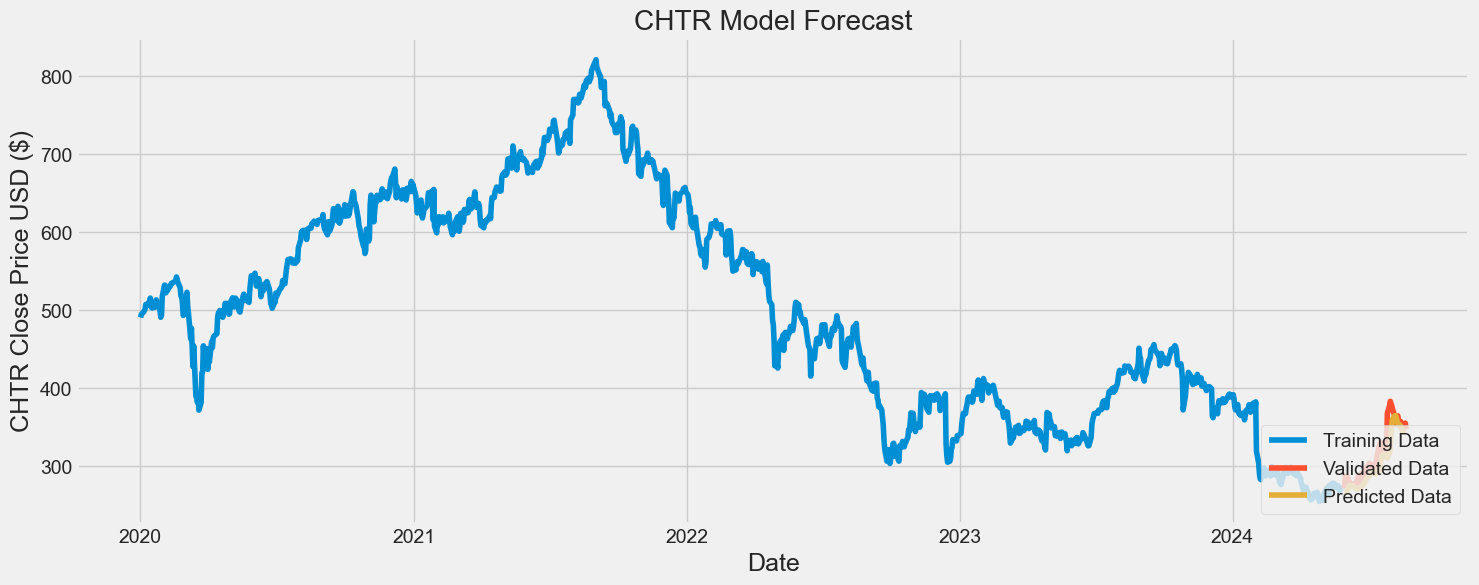

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 18.218


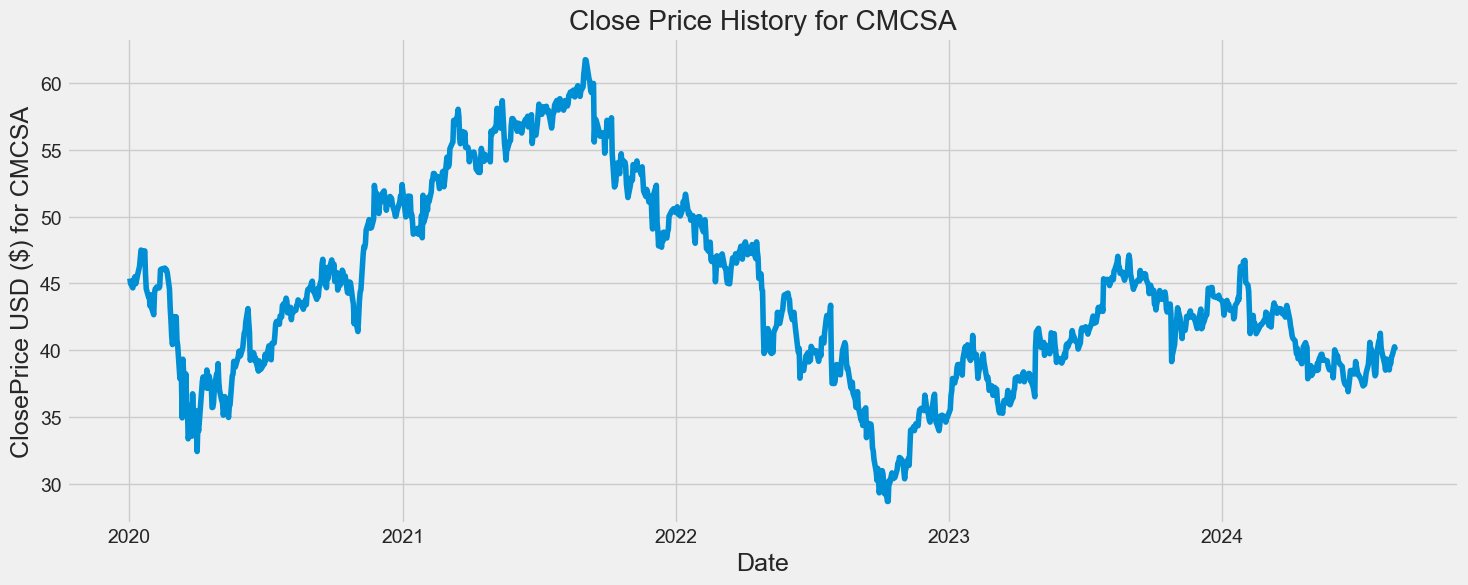

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - loss: 0.0107
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 470ms/step


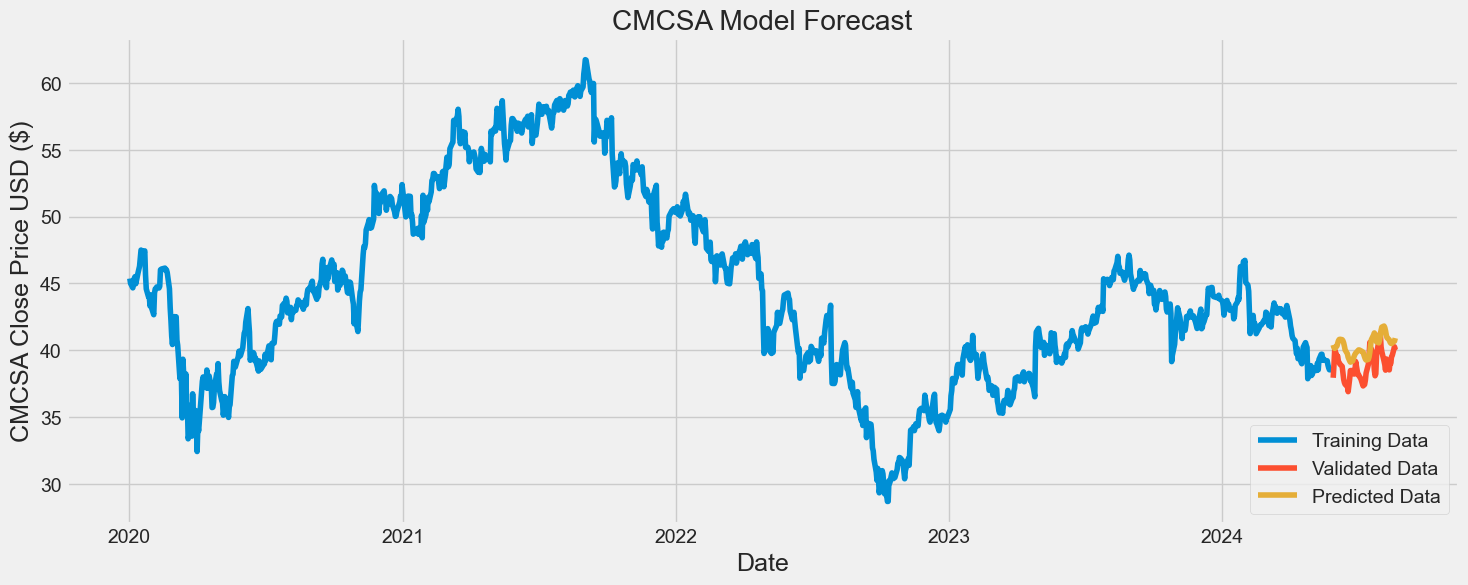

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 1.762


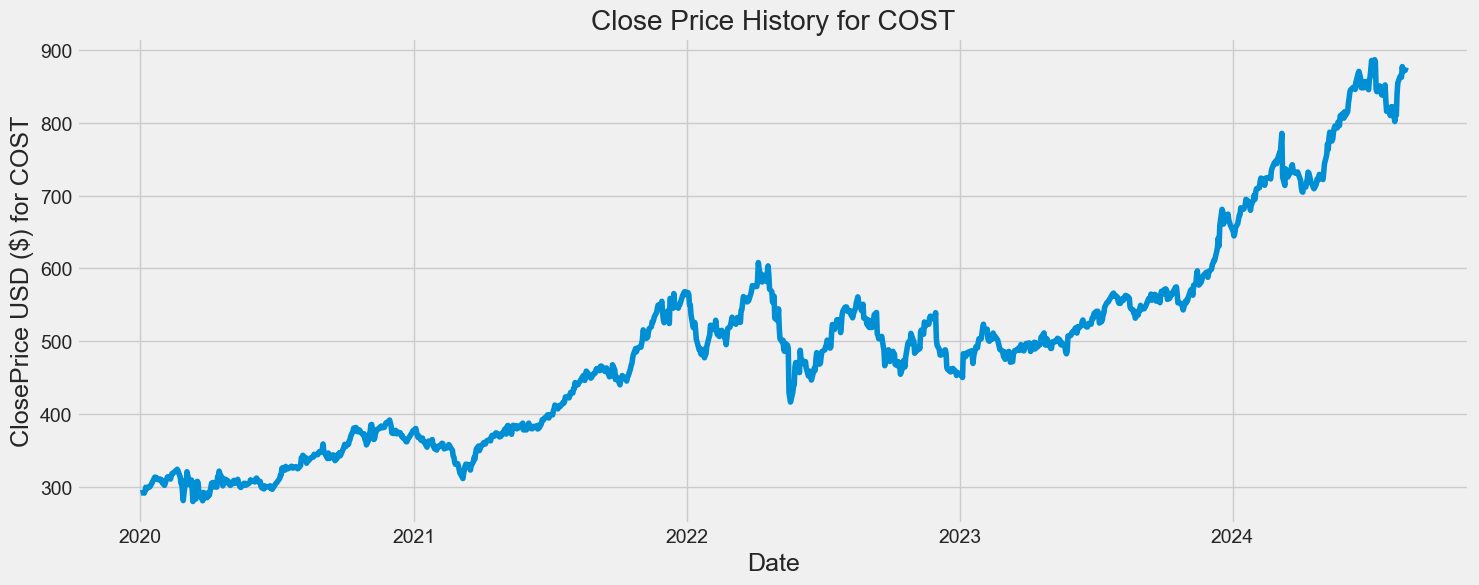

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - loss: 0.0030
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 467ms/step


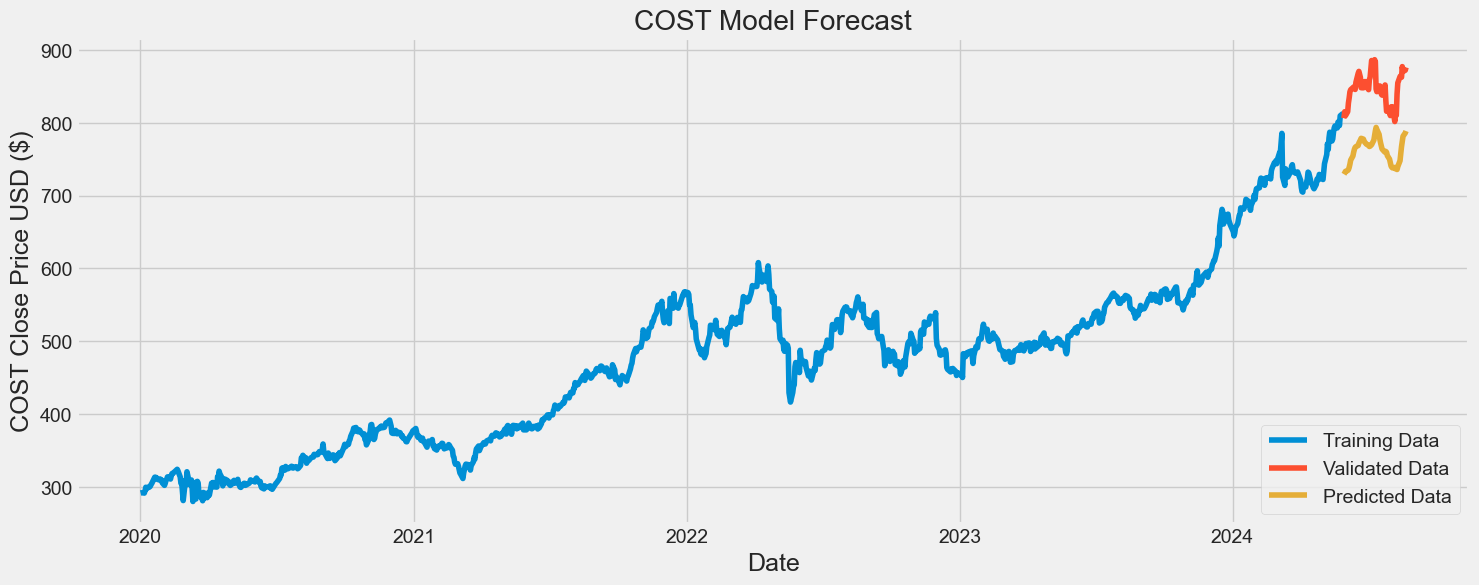

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 85.567


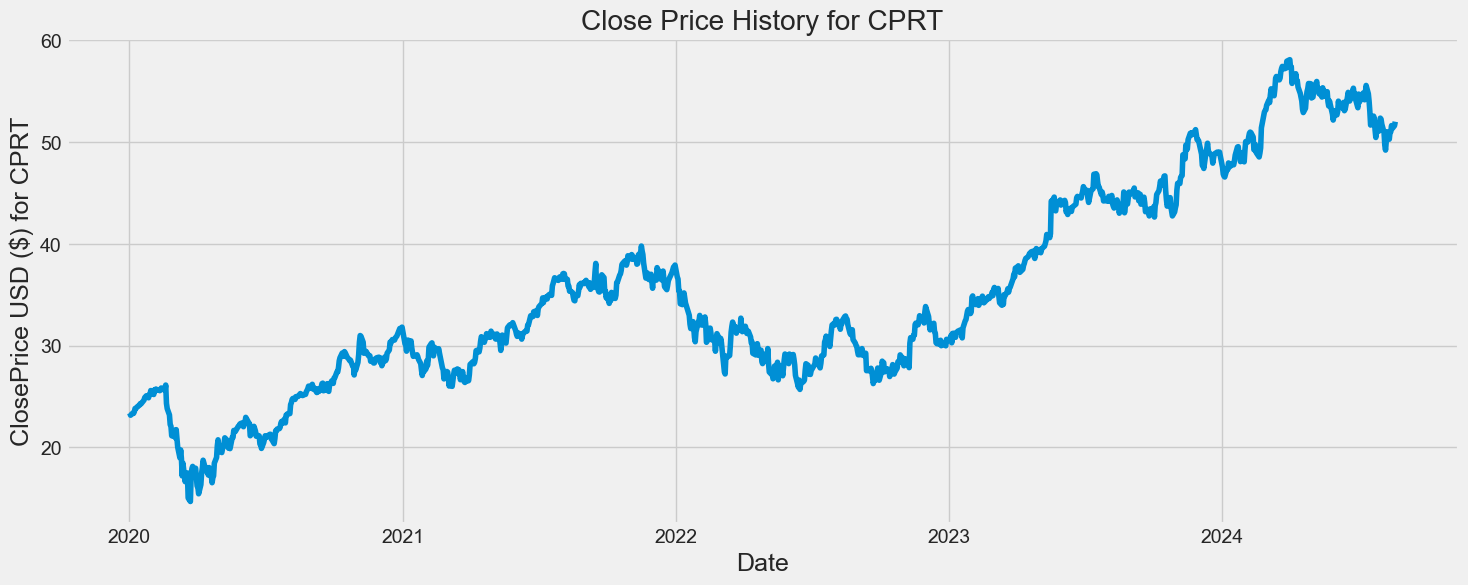

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - loss: 0.0075
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step


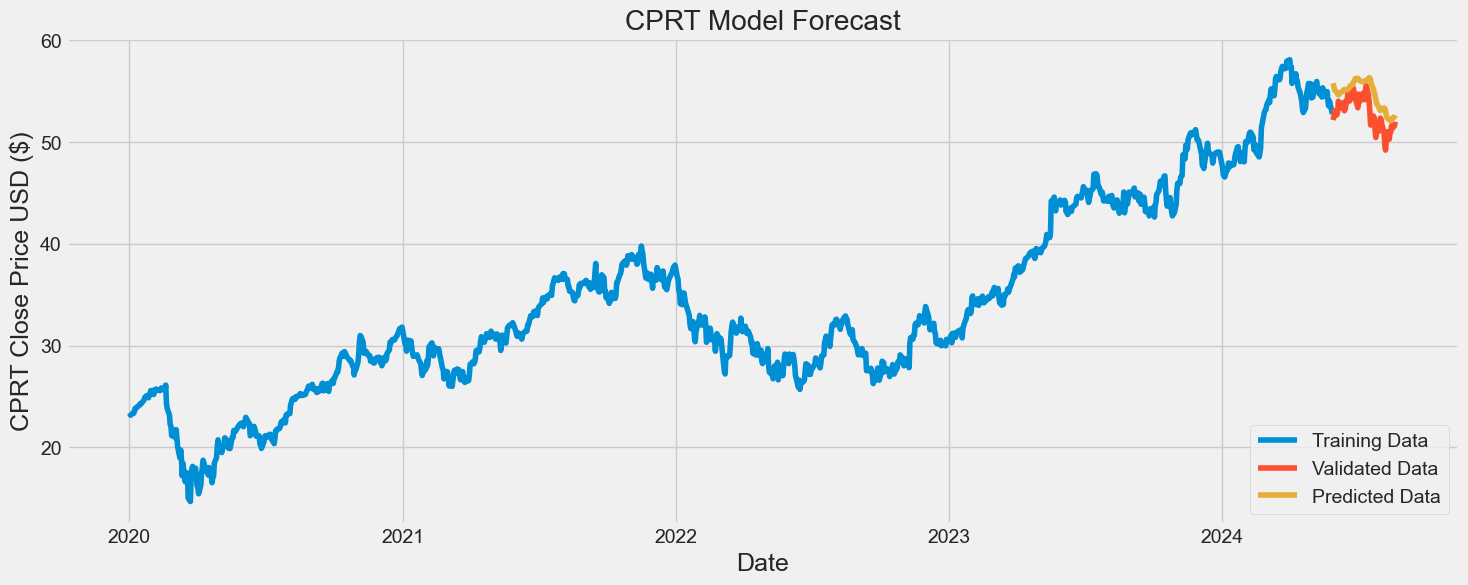

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 2.082


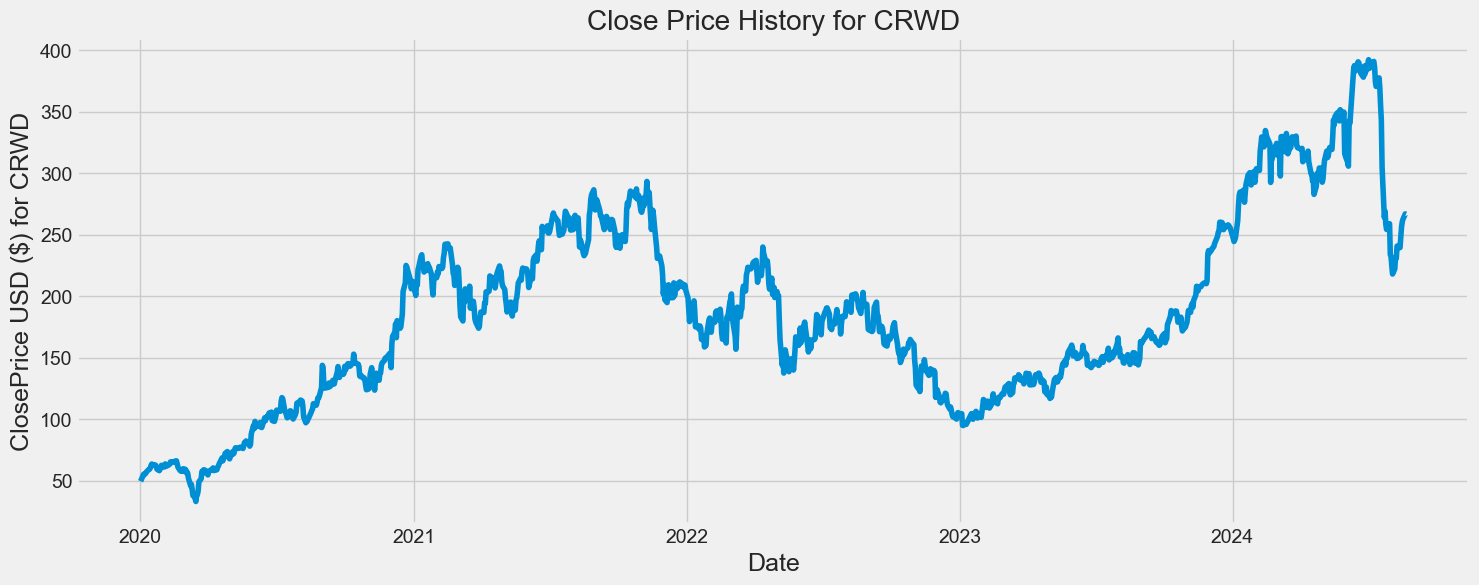

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - loss: 0.0075
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step


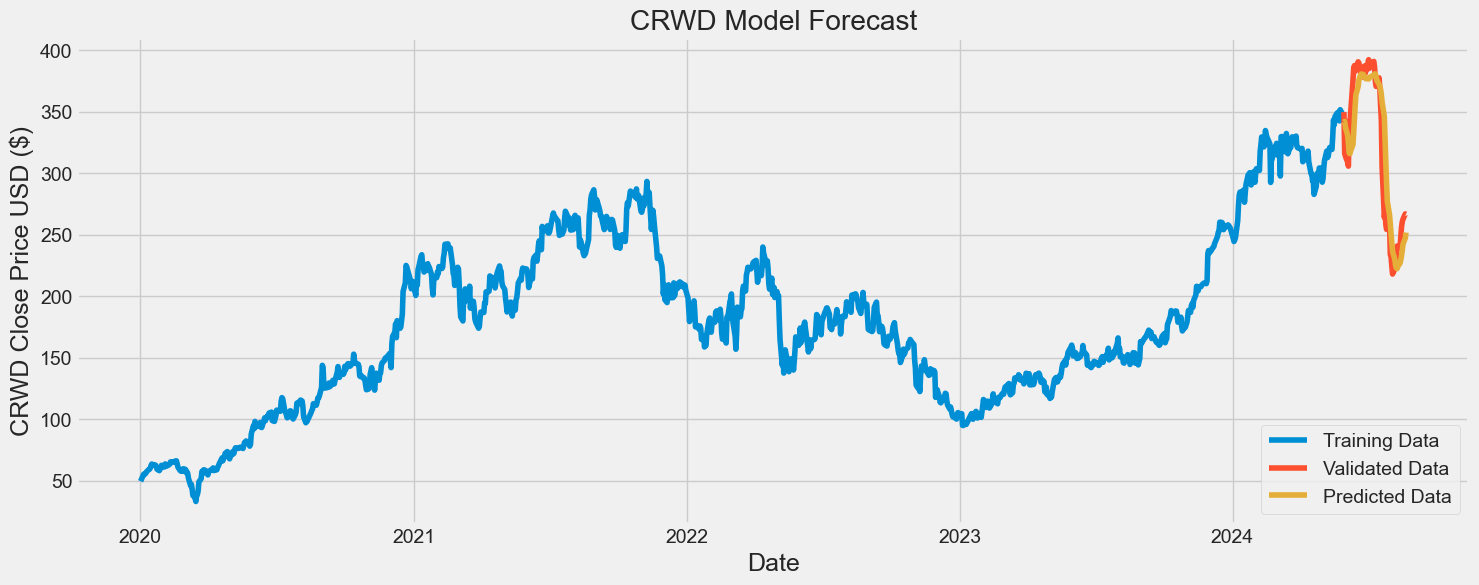

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 25.458


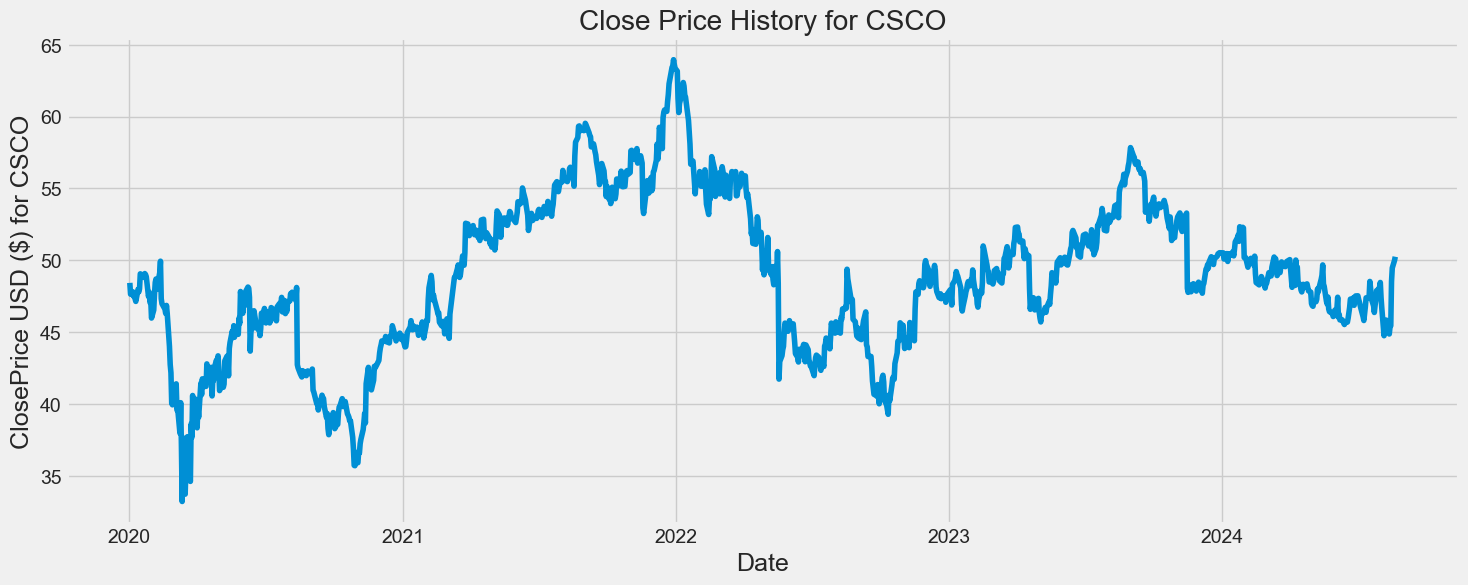

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - loss: 0.0076
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 760ms/step


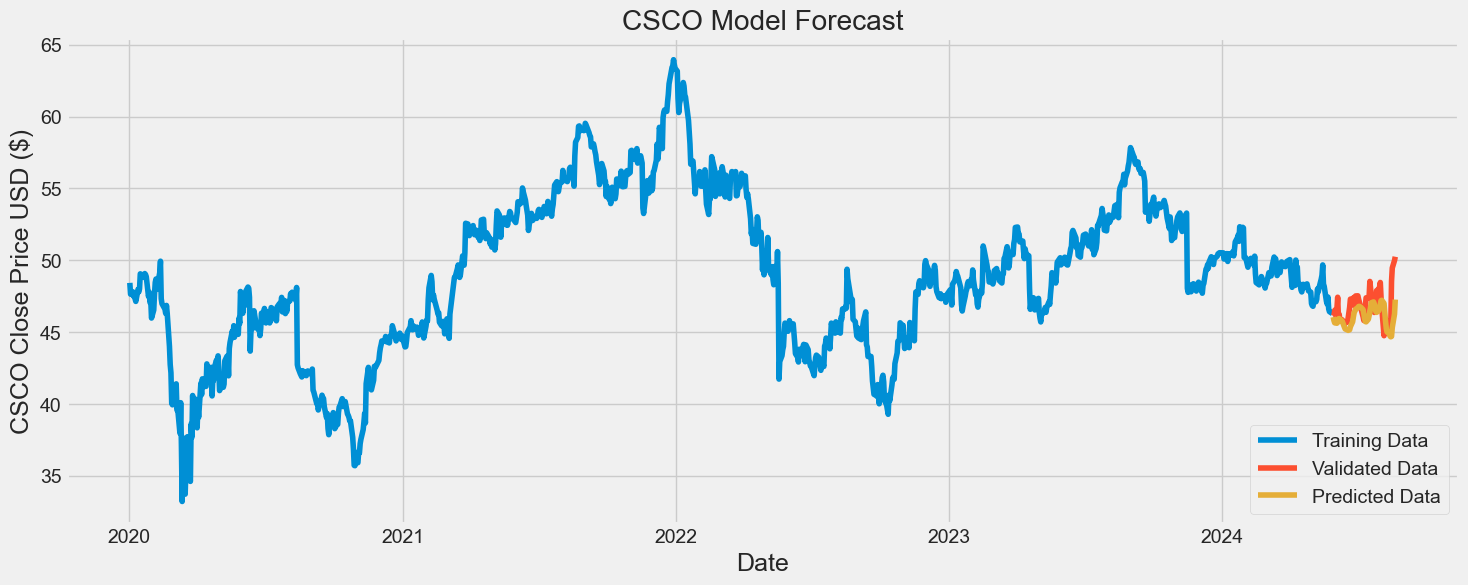

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 1.366


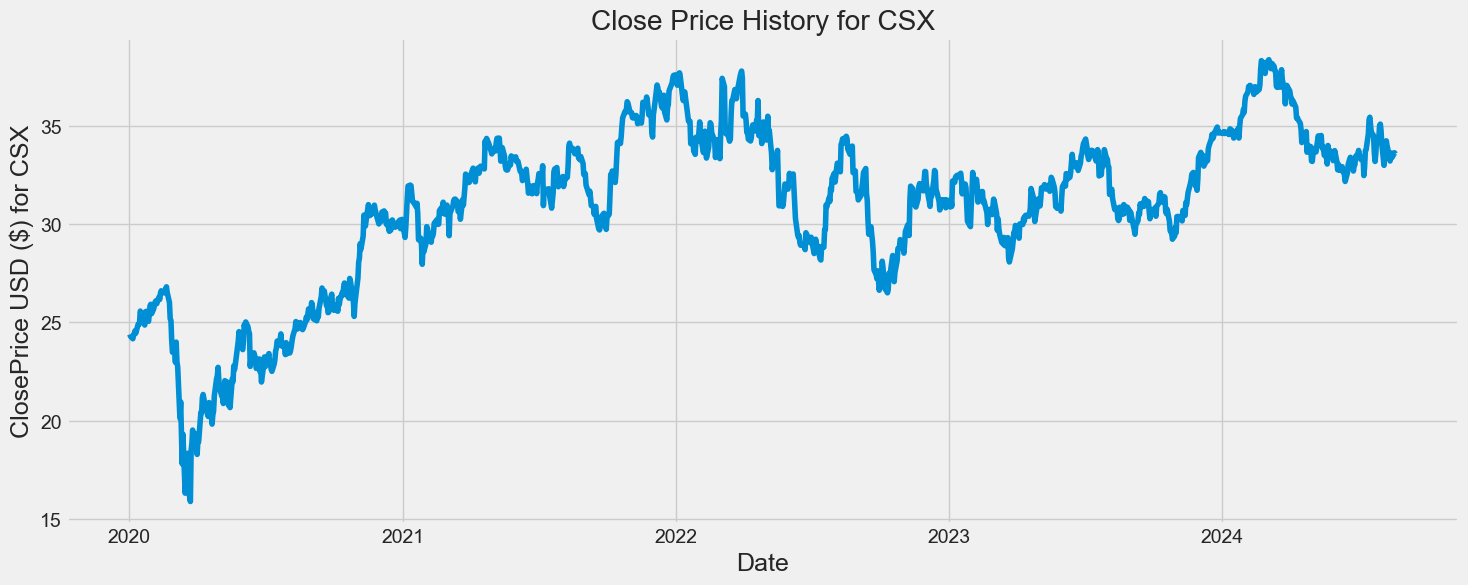

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - loss: 0.0108
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


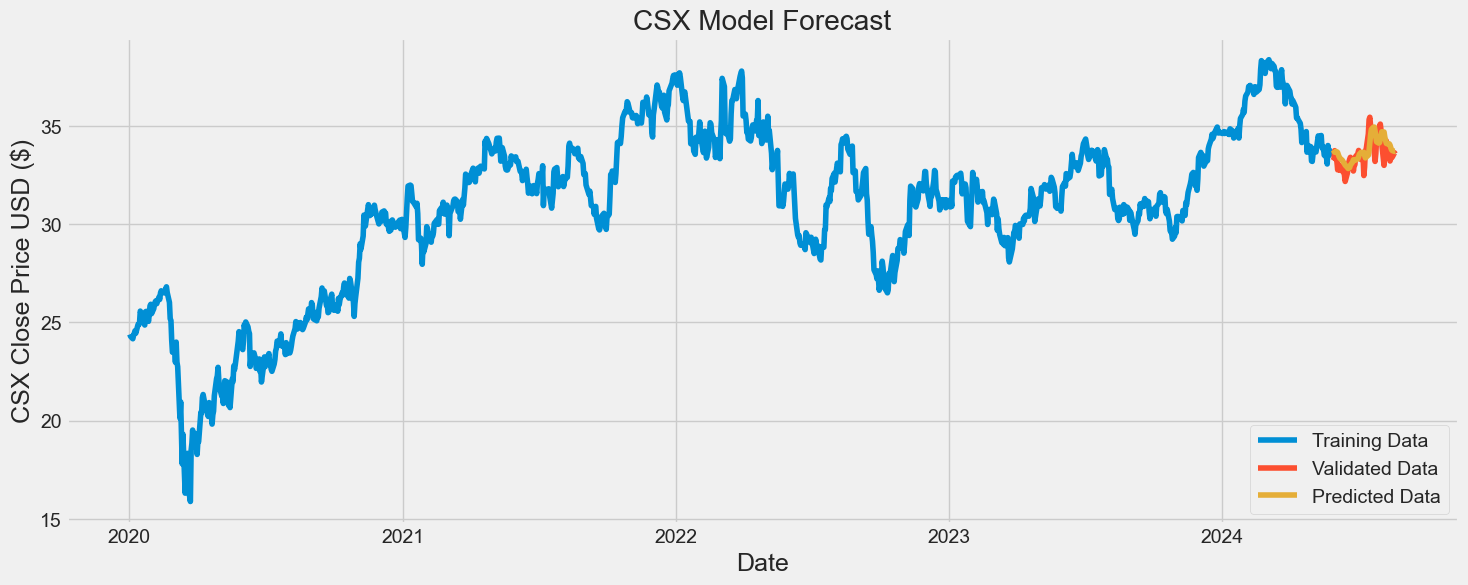

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 0.653


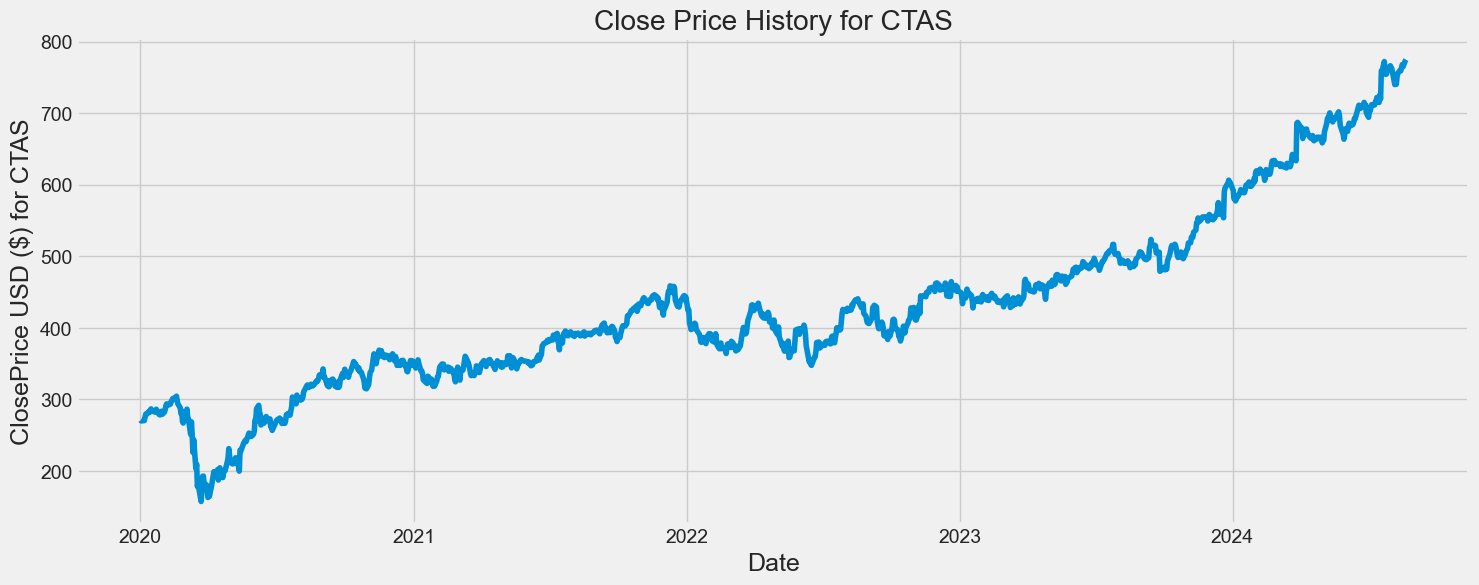

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0036
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step


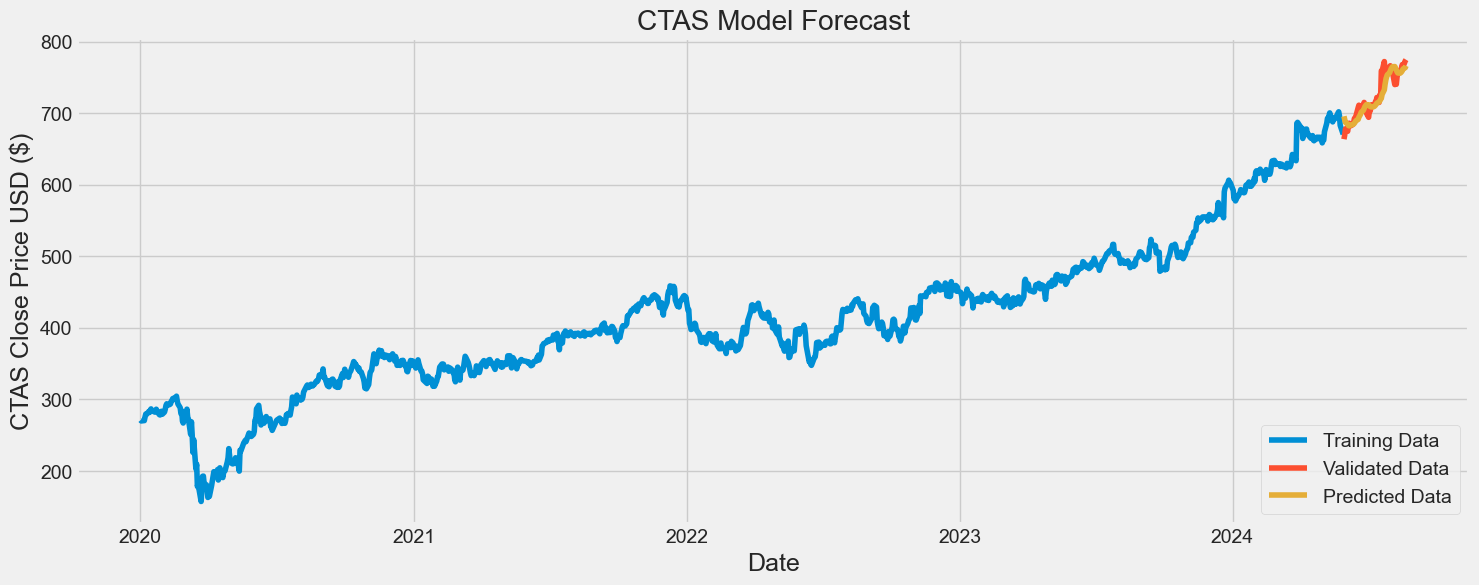

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 12.928


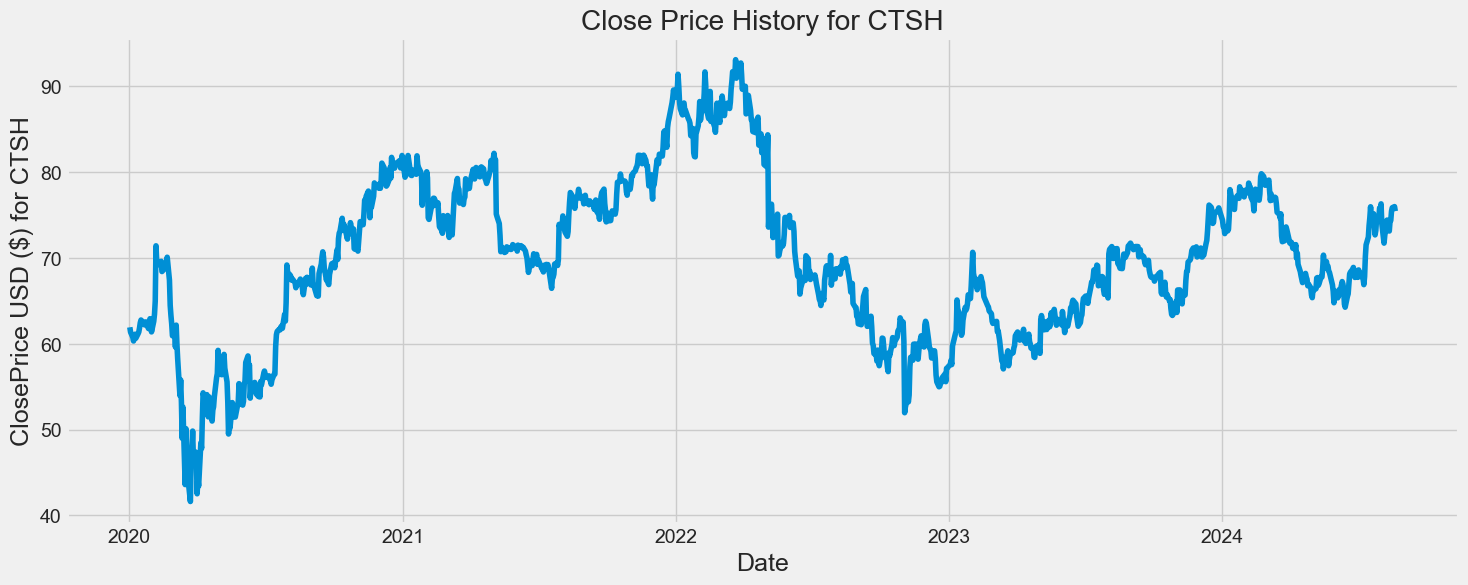

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - loss: 0.0111
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


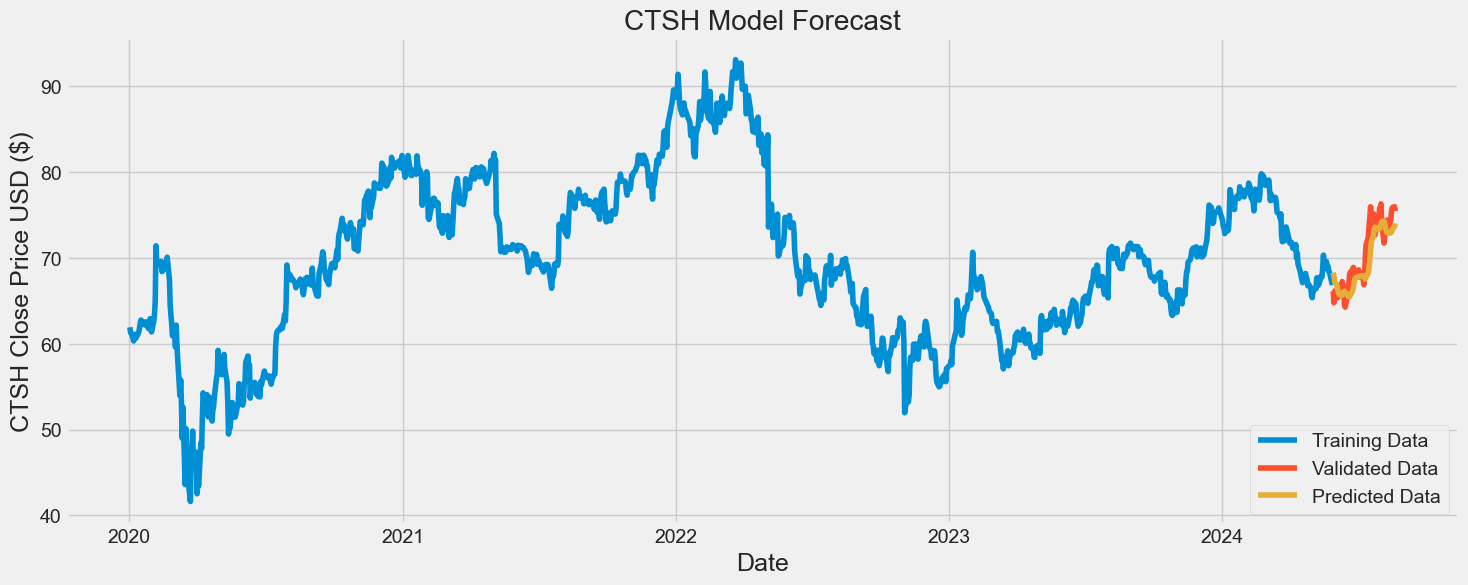

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 2.006


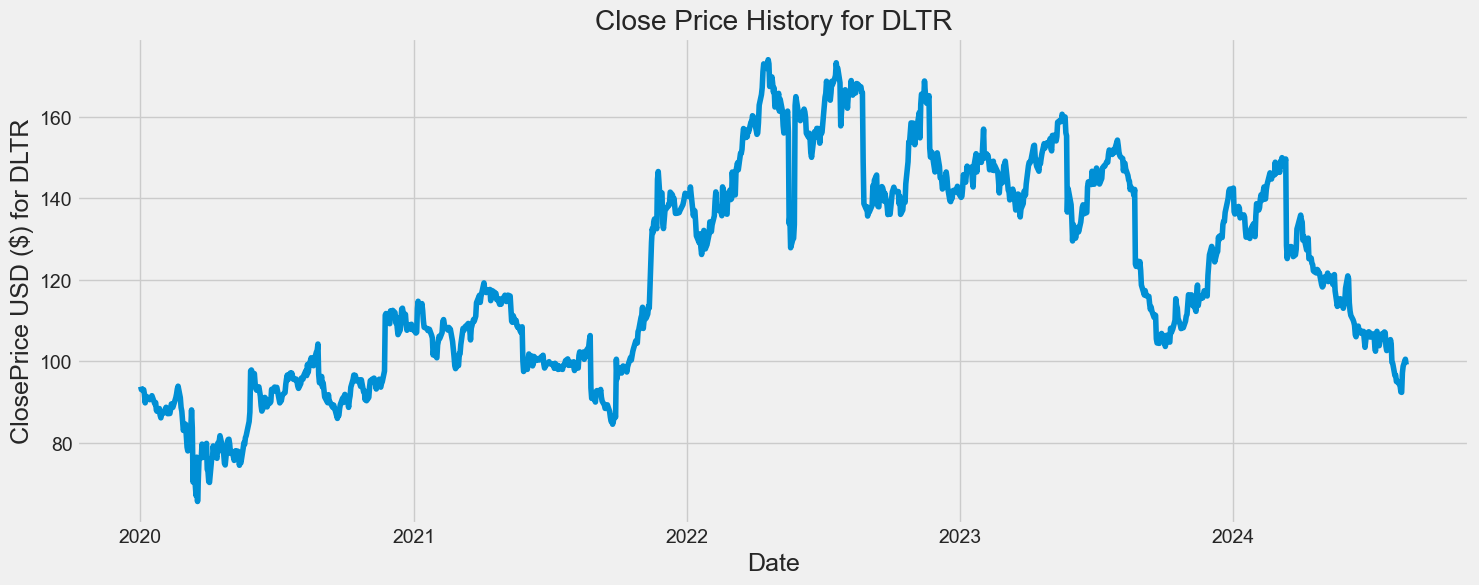

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - loss: 0.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


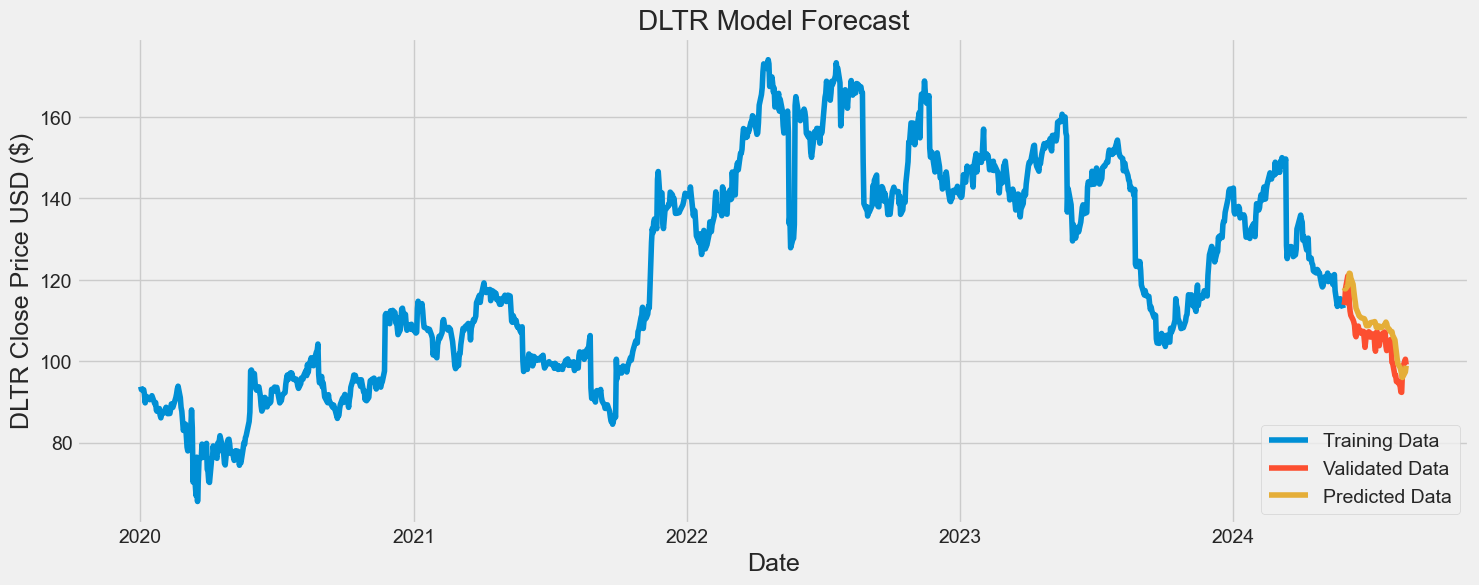

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 4.948


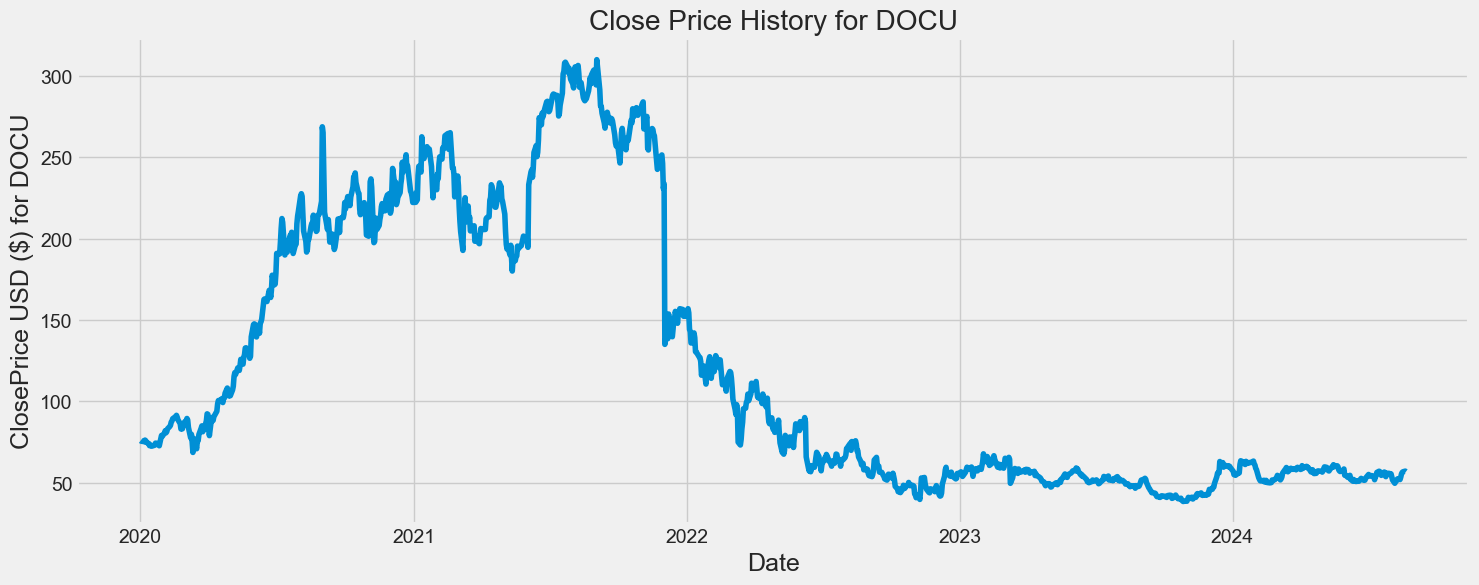

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - loss: 0.0112
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


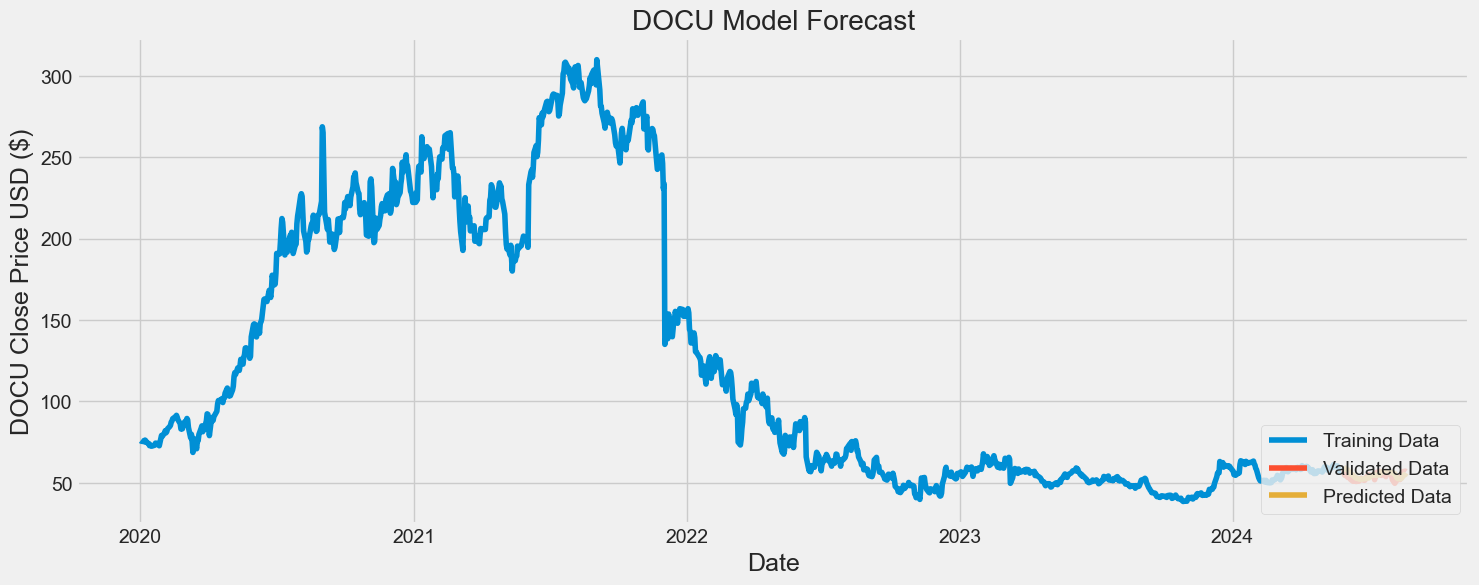

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 2.263


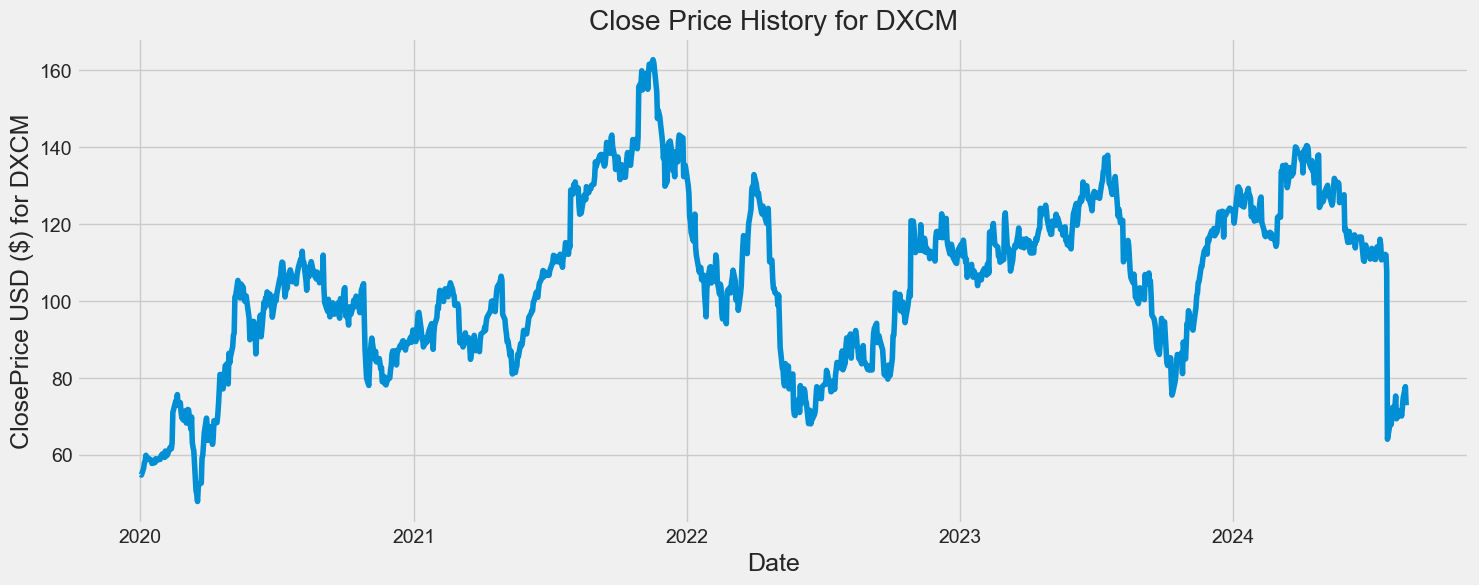

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - loss: 0.0100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step


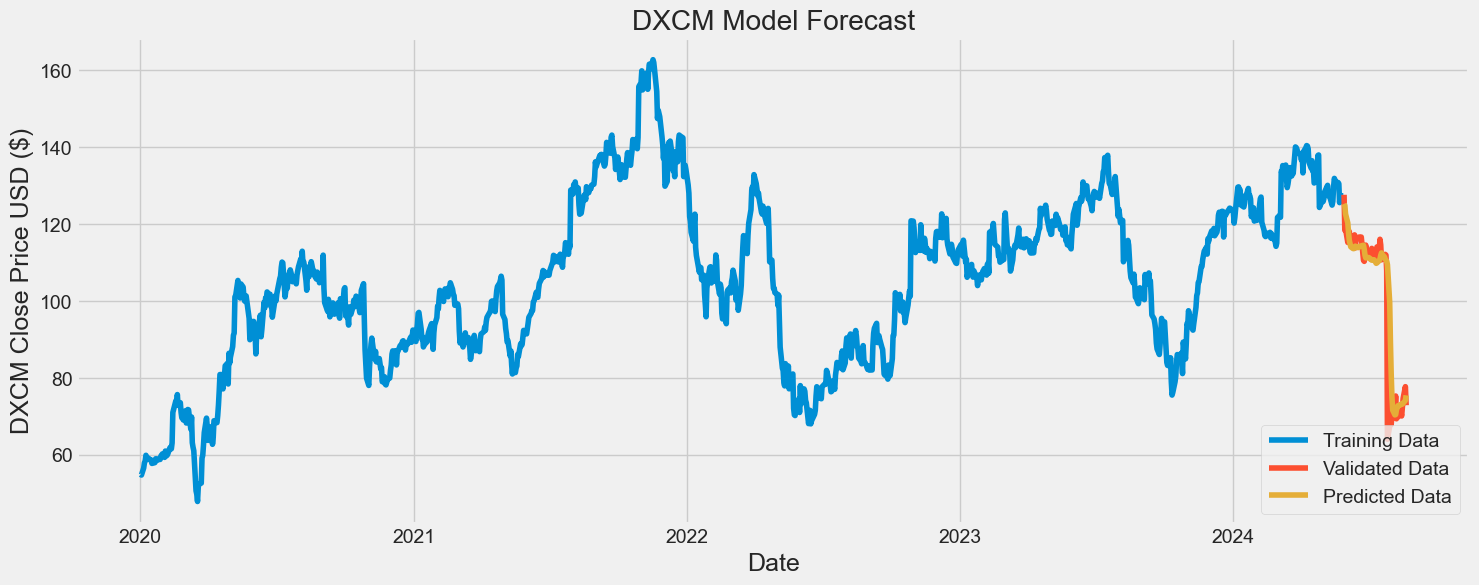

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 8.359


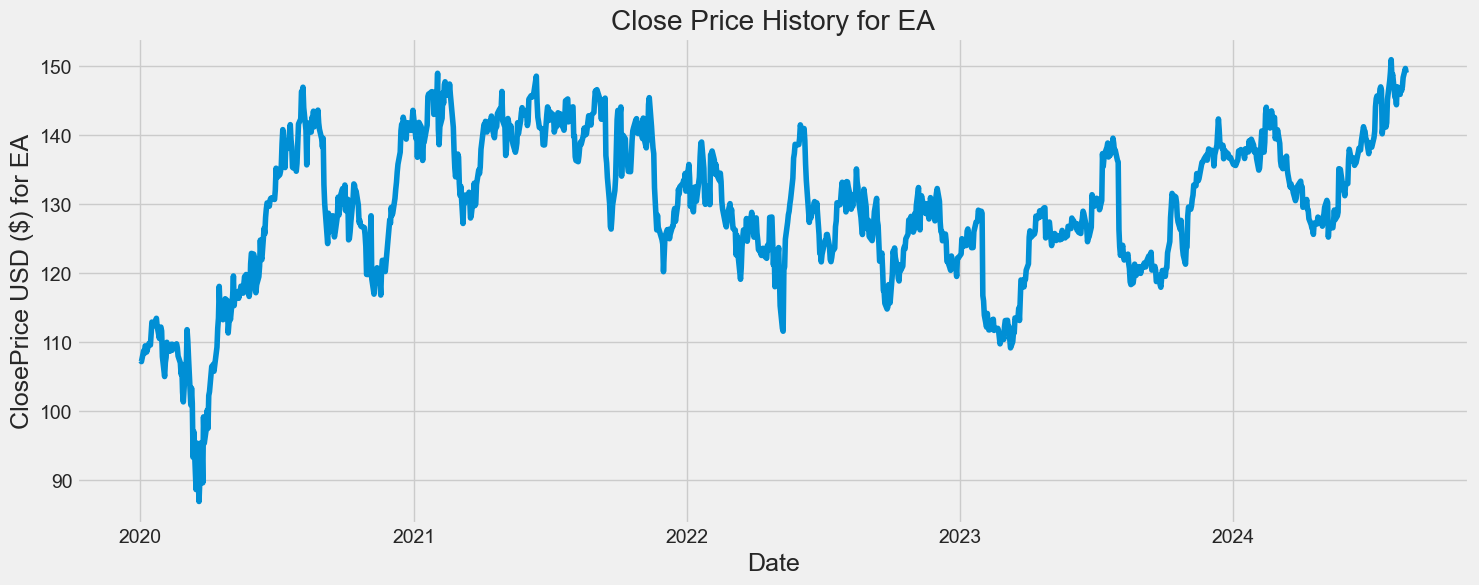

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - loss: 0.0134
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


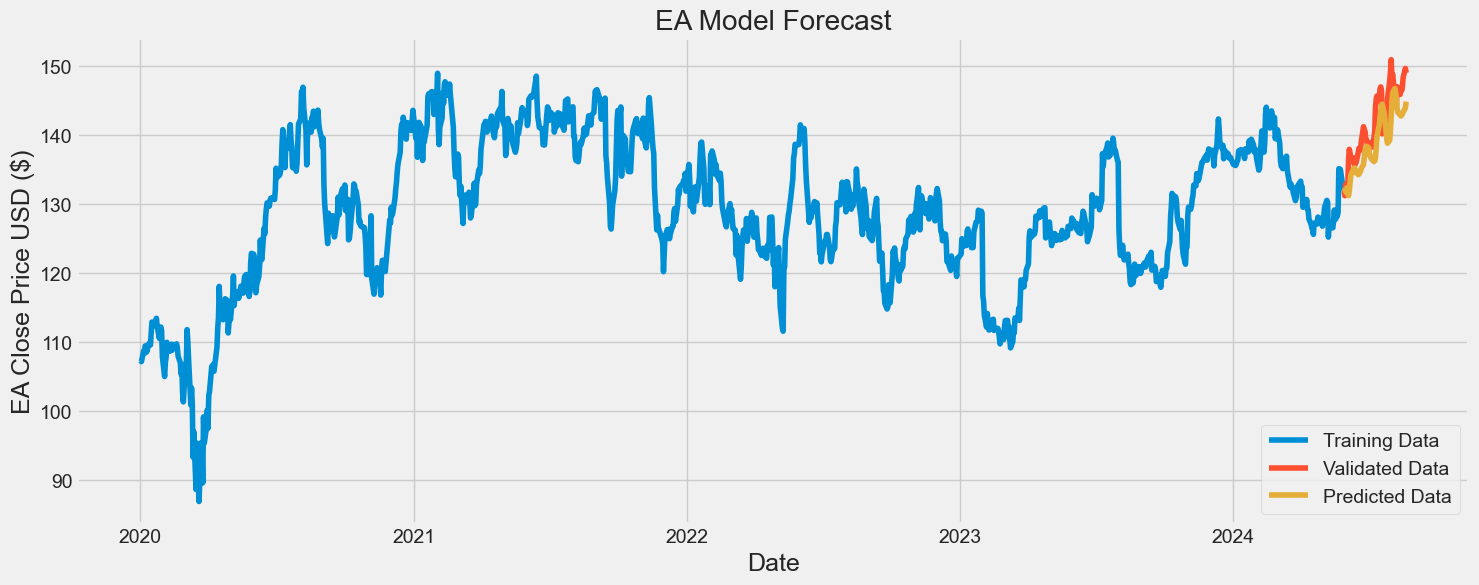

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 3.905


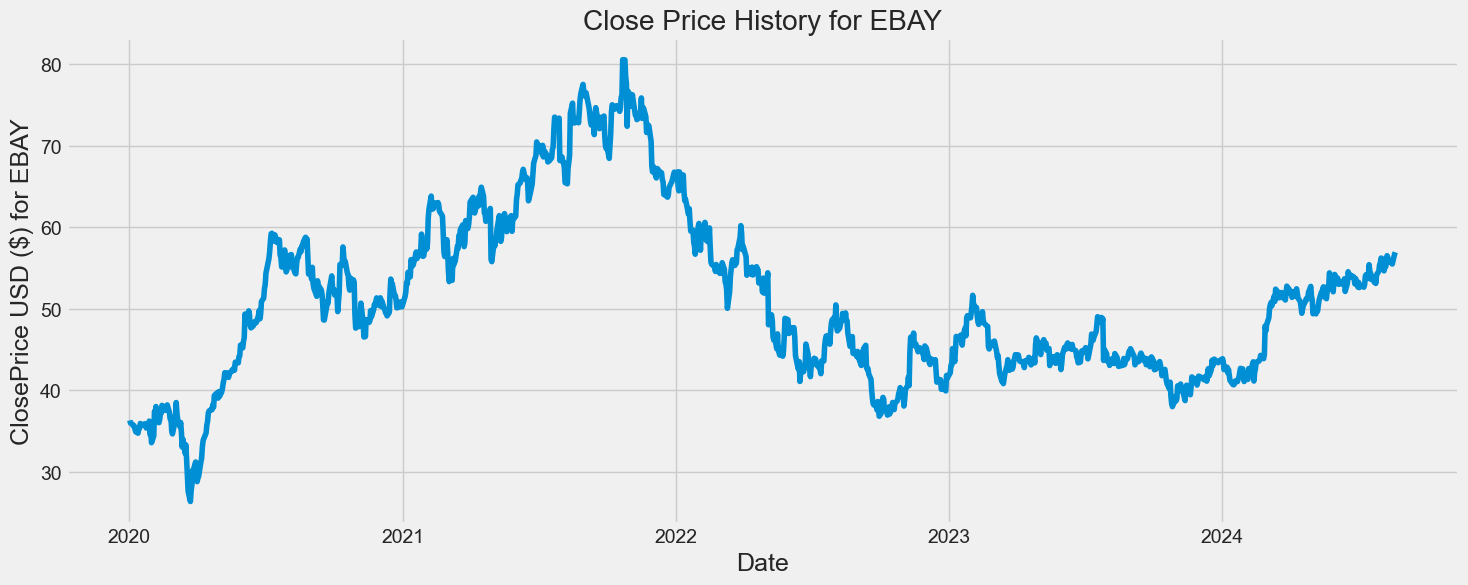

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - loss: 0.0051
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step


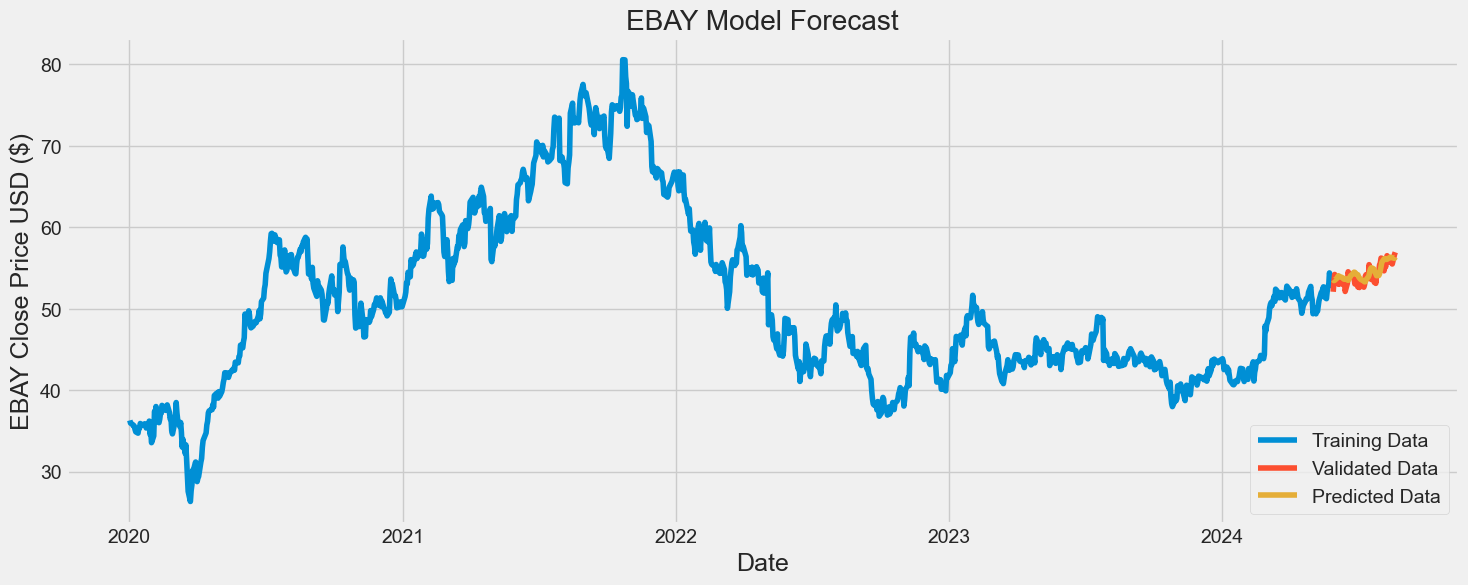

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 0.817


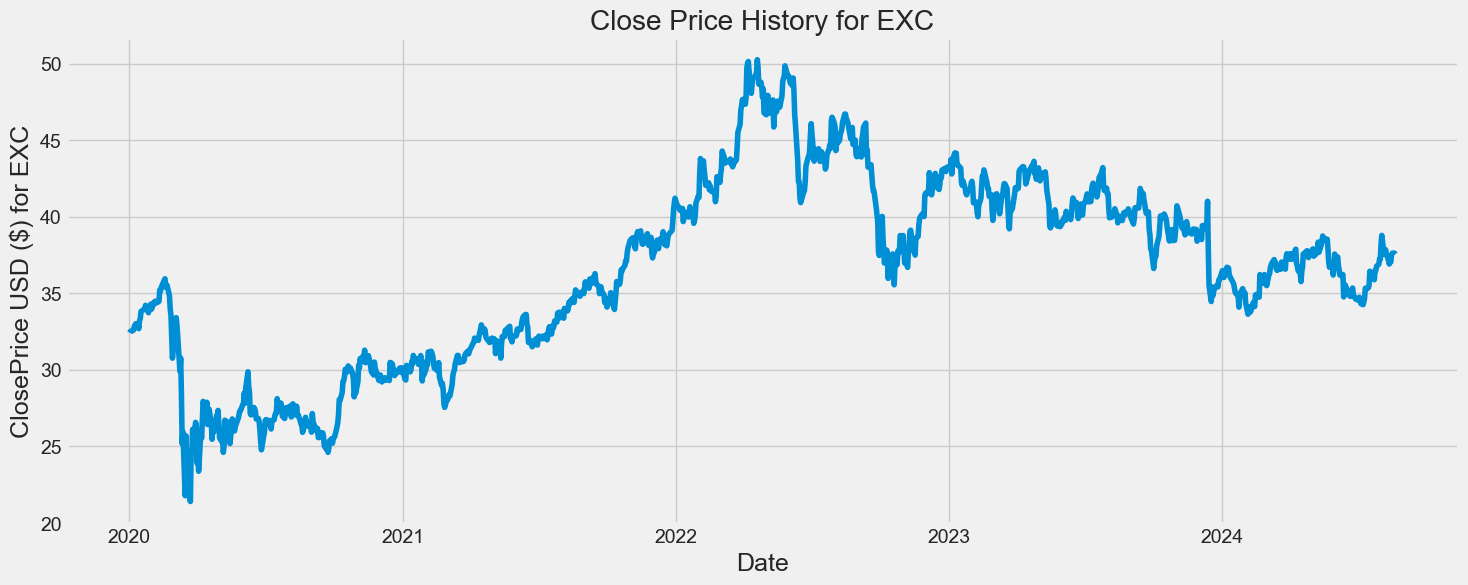

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - loss: 0.0057
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step


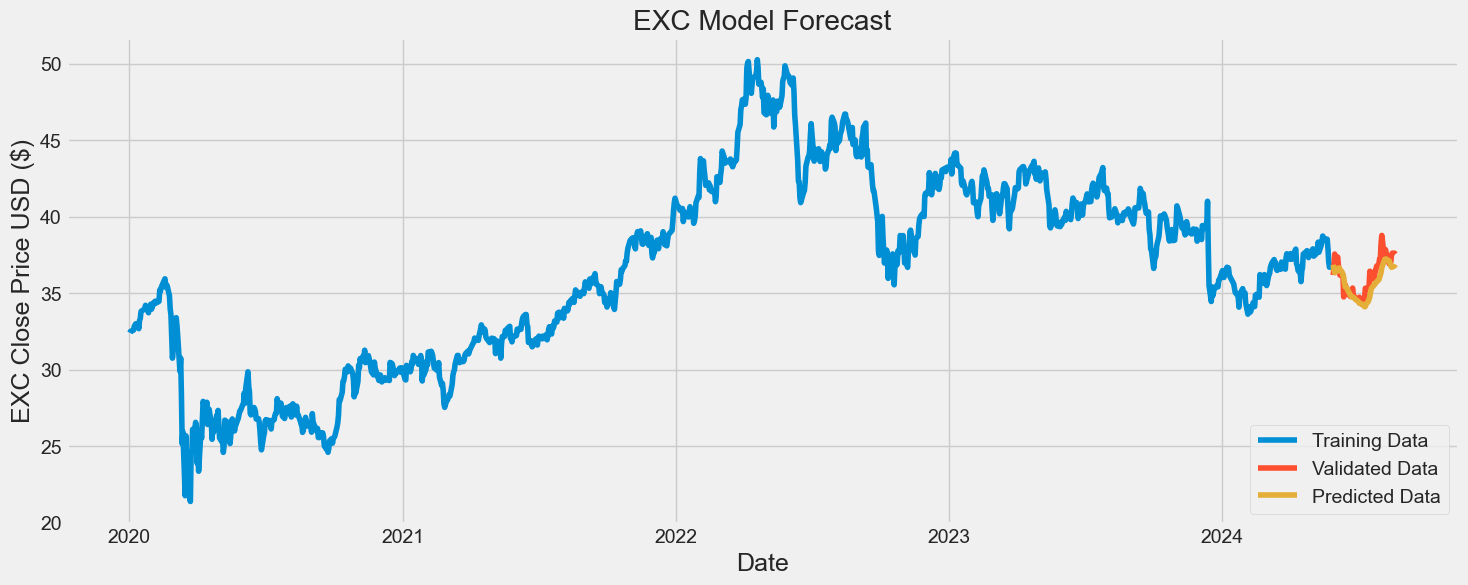

[*********************100%%**********************]  1 of 1 completed

Test RMSE: 0.761


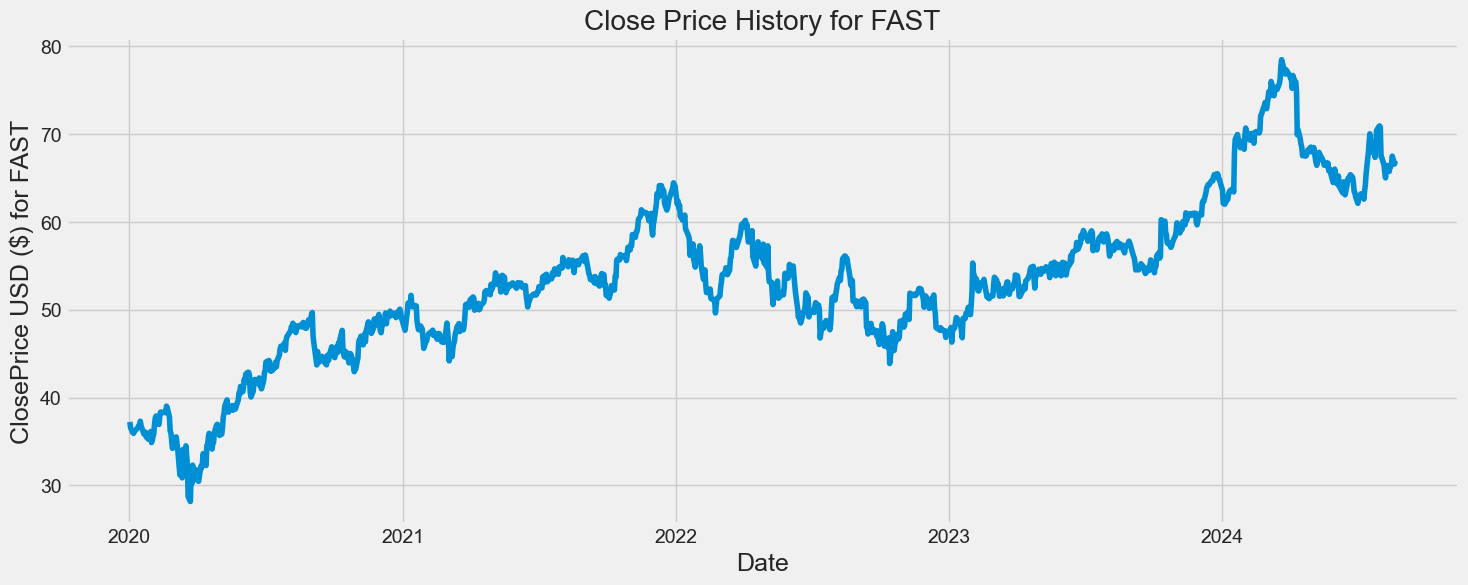

.
.
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - loss: 0.0051
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step


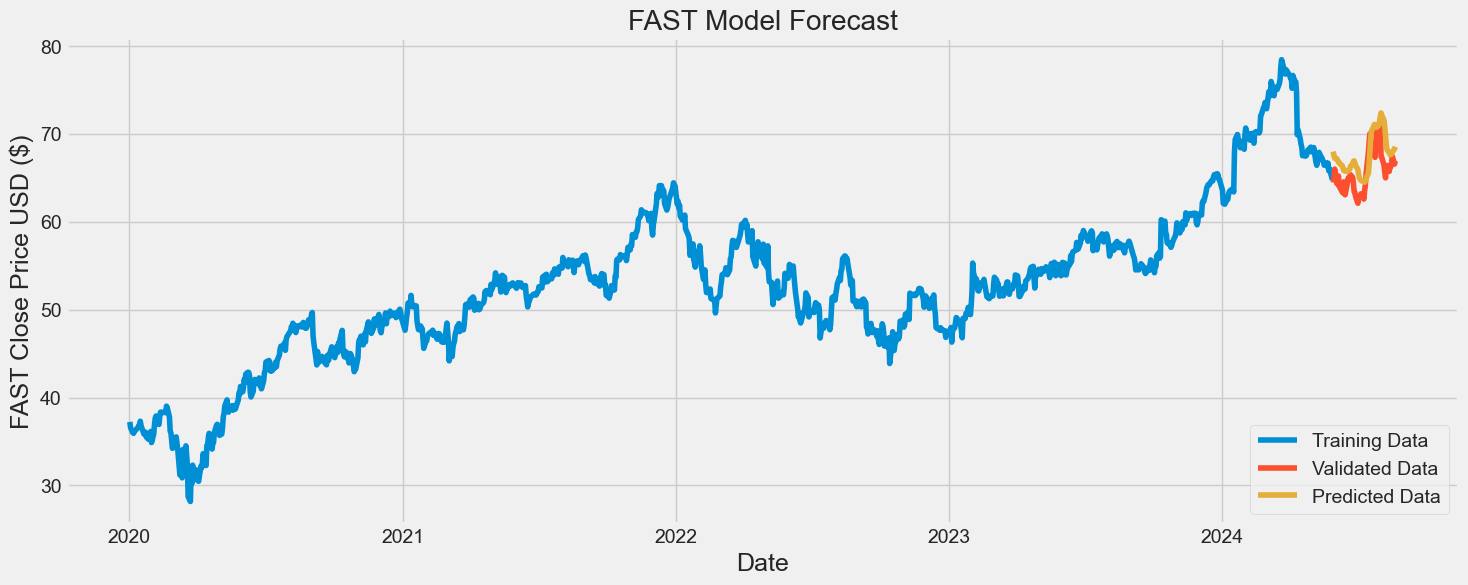

Test RMSE: 2.537
{'AAPL': 5.682060995297899, 'ADBE': 20.59058406677354, 'ADI': 6.739295667670536, 'ADP': 6.080016840492361, 'ADSK': 6.701207298961427, 'AEP': 1.9303855022731933, 'ALGN': 10.14489797131821, 'AMAT': 11.945533099524882, 'AMD': 8.057413131905829, 'AMGN': 9.086625839735797, 'AMZN': 5.812577097379825, 'ANSS': 8.63193763278972, 'ASML': 55.90733015351825, 'AVGO': 14.257315606556448, 'BIDU': 3.466367177814324, 'BIIB': 5.385249312639549, 'BKNG': 158.58209440556118, 'CDNS': 24.054679107148832, 'CDW': 7.116150334716424, 'CHKP': 6.150411479507935, 'CHTR': 18.21794365846838, 'CMCSA': 1.7621958928947985, 'COST': 85.56689905875437, 'CPRT': 2.0815020708491616, 'CRWD': 25.457776756027886, 'CSCO': 1.3663536116887587, 'CSX': 0.6527604668955599, 'CTAS': 12.928076007915577, 'CTSH': 2.005925963554001, 'DLTR': 4.948316064921558, 'DOCU': 2.2627545183221422, 'DXCM': 8.35907196578909, 'EA': 3.90455290000896, 'EBAY': 0.8170925059696699, 'EXC': 0.760676309669253, 'FAST': 2.537296272623742}


In [44]:
# stock_list = ['AMZN','TSLA','NVDA','GOOG','MSFT']
Symbols = ['AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'ALGN', 'AMAT',
    'AMD', 'AMGN', 'AMZN', 'ANSS', 'ASML', 'AVGO', 'BIDU',
    'BIIB', 'BKNG', 'CDNS', 'CDW', 'CHKP', 'CHTR', 'CMCSA',
    'COST', 'CPRT', 'CRWD', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'DLTR',
    'DOCU', 'DXCM', 'EA', 'EBAY', 'EXC', 'FAST'
]
TEST_DATA_LENGTH = 111
start_date = '2020-01-01'
error_scores = {}
print("Let us evaluate for all of NASDAQ")
for stock in Symbols:
    df = collect_data(stock,start_date) #Collect the data
    plot_close_val(df, 'Close', stock) # Plot the Closing Price
    #plot_close_val(df, 'Open', stock) # Plot the Opening Price
    #print(df.head()) # Print Dataframe check
    training_data_df, training_dataset_np, training_data_len = build_training_dataset(df) #Build the Training Dataset
    dataset=training_dataset_np
    data=training_data_df
    scaler, scaled_data = scale_the_data(training_dataset_np) #Scale the data
    x_train,y_train = split_train_dataset(training_data_len) #split the data
    lstm_model = build_lstm_model(x_train,y_train) #build the LSTM model 
    x_test,y_test, predictions, rmse = create_testing_data_set(lstm_model,scaler,training_data_len, TEST_DATA_LENGTH ) #create testing dataset and predictions
    valid = plot_predictions(stock,data,training_data_len) #plot predictions
    valid   # Show the valid and predicted prices
    rmse = sqrt(mean_squared_error(valid['Close'], valid['Predictions']))
    print('Test RMSE: %.3f' % (rmse))
    #error_scores.append(rmse)
    error_scores[stock] = rmse

print(error_scores)